In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from math import ceil
from os.path import join
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

import warnings
sns.set()
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data_preprocessed_RobustScaler_activities.csv', sep=',')

In [3]:
data.head()

,ID,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,...,Dropout,Gender_binary,Athletics,Water,Fitness,Team,Racket,Combat,Special,Other
0,10000,3.083333,-0.571429,-0.282972,-0.243243,2.333333,-2.333333,-0.929988,-0.333333,-0.5,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,10001,0.500000,0.271429,1.213861,0.135135,0.333333,-1.666667,-0.613263,-0.500000,0.5,...,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10002,0.000000,-0.485714,-0.481666,-0.324324,0.000000,0.000000,-0.254744,0.333333,-0.5,...,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10003,-1.166667,-0.271429,-0.029372,0.054054,0.666667,-1.666667,-0.604734,-0.166667,-0.5,...,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,10005,0.083333,-0.542857,-0.088501,0.270270,0.000000,0.000000,0.569195,3.666667,-0.5,...,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data.set_index('ID', inplace=True)

In [5]:
non_metric_features=['UseByTime', 'Dropout','Gender_binary','Athletics', 'Water', 'Fitness', 'Team', 'Racket','Combat', 'Special', 'Other']


metric_features =  ['Age','DaysWithoutFrequency', 'LifetimeValue','NumberOfFrequencies', 'AttendedClasses',
                    'AllowedWeeklyVisits','AllowedNVisits', 'NVisits', 'NRenewals','NReferences','EnrollmentTime',
                    'DaysSinceLastVisit','NActivities','AvgLifeTimeValue']

In [6]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

# Hierarchical Clustering

In [7]:
df = data.copy()

In [8]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df[metric_features])
hc_labels

array([2, 2, 2, ..., 2, 1, 2])

In [9]:
# Characterizing the clusters
df_concat = pd.concat((df, pd.Series(hc_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,...,Dropout,Gender_binary,Athletics,Water,Fitness,Team,Racket,Combat,Special,Other
labels,,,,,,,,,,,,,,,,,,,,,
0,-0.376016,0.214395,1.652382,0.856316,12.981707,-1.404980,-0.465114,0.129192,0.450838,0.054878,...,0.669970,0.580030,0.000762,0.745427,0.102134,0.132622,0.070884,0.032012,0.022104,0.001524
1,0.003125,-0.190446,4.716467,4.529899,56.508333,-1.256250,-0.341995,0.844792,1.428125,0.168750,...,0.300000,0.531250,0.000000,0.825000,0.156250,0.062500,0.031250,0.037500,0.031250,0.000000
2,0.334651,0.397773,0.185422,0.396859,0.467830,-0.338603,0.145727,0.213754,-0.039361,0.011117,...,0.841074,0.602931,0.008152,0.217721,0.653080,0.041749,0.017951,0.118989,0.024621,0.001647
3,-0.481707,-0.065645,3.683389,2.375280,30.778049,-1.371545,-0.448862,0.316667,1.091463,0.119512,...,0.380488,0.570732,0.007317,0.863415,0.095122,0.112195,0.024390,0.014634,0.017073,0.000000
4,0.267361,11.437143,0.670764,0.226351,1.162500,-0.481944,0.029674,-0.131250,1.093750,0.020833,...,0.712500,0.587500,0.004167,0.220833,0.587500,0.154167,0.050000,0.120833,0.012500,0.000000


In [10]:
# Computing SST
X = df[metric_features].values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [11]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        
        
        # get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        
        # concat df with labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels', index=df.index)), axis=1)  
        
        
        # compute ssw for each cluster labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  
        
        
        # remember: SST = SSW + SSB
        ssb = sst - np.sum(ssw_labels)  
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='sc

findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalab

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansInscriptionalParthian-Regular.ttf', name='Noto Sans Inscriptional Parthian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHatran-Regular.ttf', name='Noto Sans Hatran', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/AquaKana.ttc', name='.Aqua Kana', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCoptic-Regular.ttf', name='Noto Sans Coptic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gujarati Sangam MN.ttc', name='Gujarati Sangam MN', style='normal', variant='normal',

findfont: score(FontEntry(fname='/System/Library/Fonts/Keyboard.ttf', name='.Keyboard', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kokonor.ttf', name='Kokonor', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLinearA-Regular.ttf', name='Noto Sans Linear A', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansManichaean-Regular.ttf', name='Noto Sans Manichaean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNewTaiLue-Regular.ttf', name='Noto Sans New Tai Lue', style='normal', variant='normal', weight=400, stretch='normal', size

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Georgia Italic.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSaurashtra-Regular.ttf', name='Noto Sans Saurashtra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Corsiva.ttc', name='Corsiva Hebrew', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOlChiki-Regular.ttf', name='Noto Sans Ol Chiki', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldItalic-Regular.ttf', name='Noto Sans Old Italic', style='italic', variant='normal', weight=400, 

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansAvestan-Regular.ttf', name='Noto Sans Avestan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBuginese-Regular.ttf', name='Noto Sans Buginese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Raanana.ttc', name='Raanana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Comic Sans MS Bold.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Lao MN.ttc', name='Lao MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXNonUniIta.otf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMiao-Regular.ttf', name='Noto Sans Miao', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/InaiMathi-MN.ttc', name='InaiMathi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Telugu MN.ttc', name='Telugu MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
fin

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Khmer MN.ttc', name='Khmer MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldNorthArabian-Regular.ttf', name='Noto Sans Old North Arabian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SnellRoundhand.ttc', name='Snell Roundhand', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizFiveSymReg.otf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNabataean-Regular.ttf', name='Noto Sans Nabataean', style='normal', variant='normal', weight

findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W8.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Damascus.ttc', name='Damascus', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSylotiNagri-Regular.ttf', name='Noto Sans Syloti Nagri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Cochin.ttc', name='Cochin', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMarchen-Regular.ttf', name='Noto Sans Marchen', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.0

findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSMonoItalic.ttf', name='.SF NS Mono', style='italic', variant='normal', weight=295, stretch='normal', size='scalable')) = 11.14975
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMultani-Regular.ttf', name='Noto Sans Multani', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldPermic-Regular.ttf', name='Noto Sans Old Permic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Papyrus.ttc', name='Papyrus', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='sca

findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='norma

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/GillSans.ttc', name='Gill Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman Bold.ttf', name='Times New Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trattatello.ttf', name='Trattatello', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansGothic-Regular.ttf', name='Noto Sans Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Chalkduster.ttf', name='Chalkduster', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 1

findfont: score(FontEntry(fname='/System/Library/Fonts/NotoSansArmenian.ttc', name='Noto Sans Armenian', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/System/Library/Fonts/SFArabic.ttf', name='.SF Arabic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldSouthArabian-Regular.ttf', name='Noto Sans Old South Arabian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldHungarian-Regular.ttf', name='Noto Sans Old Hungarian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Avenir Next.ttc', name='Avenir Next', style='normal', variant='normal', weight=700, stretch='normal', size='scala

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Waseem.ttc', name='Waseem', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Symbol.ttf', name='Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Mishafi.ttf', name='Mishafi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gurmukhi MN.ttc', name='Gurmukhi MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Shree714.ttc', name='Shree Devanagari 714', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXGeneral.otf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXGeneralBol.otf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Brush Script.ttf', name='Brush Script MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/System/Library/Fonts/KohinoorTelugu.ttc', name='Kohinoor Telugu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gurmukhi Sangam MN.ttc', name='Gurmukhi Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
fin

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTaiViet-Regular.ttf', name='Noto Sans Tai Viet', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXNonUniBol.otf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHanunoo-Regular.ttf', name='Noto Sans Hanunoo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/MuktaMahee.ttc', name='Mukta Mahee', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trebuchet MS Bold Italic.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=700, stretch='normal', siz

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansKaithi-Regular.ttf', name='Noto Sans Kaithi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansChakma-Regular.ttf', name='Noto Sans Chakma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBrahmi-Regular.ttf', name='Noto Sans Brahmi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansKayahLi-Regular.ttf', name='Noto Sans Kayah Li', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/EuphemiaCAS.ttc', name='Euphemia UCAS', style='normal', variant='normal', weight=

findfont: score(FontEntry(fname='/System/Library/Fonts/Helvetica.ttc', name='Helvetica', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni Ornaments.ttf', name='Bodoni Ornaments', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Khmer Sangam MN.ttf', name='Khmer Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Optima.ttc', name='Optima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOsage-Regular.ttf', name='Noto Sans Osage', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fn

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Lao Sangam MN.ttf', name='Lao Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntSmReg.otf', name='STIXIntegralsSm', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizTwoSymReg.otf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Hoefler Text Ornaments.ttf', name='Hoefler Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni 72 OS.ttc', name='Bodoni 72 Oldstyle', style='normal', variant='normal', weight=400, stretch='normal', size='sca

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldPersian-Regular.ttf', name='Noto Sans Old Persian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Baghdad.ttc', name='Baghdad', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/AppleGothic.ttf', name='AppleGothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Library/Fonts/Arial Unicode.ttf', name='Arial Unicode MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trebuchet MS Italic.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfon

findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 3.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='sc

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXGeneralItalic.otf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Unicode.ttf', name='Arial Unicode MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSRounded.ttf', name='.SF NS Rounded', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCham-Regular.ttf', name='Noto Sans Cham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBatak-Regular.ttf', name='Noto Sans Batak', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'))

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Italic.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Iowan Old Style.ttc', name='Iowan Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntUpSmBol.otf', name='STIXIntegralsUpSm', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Songti.ttc', name='Songti SC', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Marion.ttc', name='Marion', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntr

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/ITFDevanagari.ttc', name='ITF Devanagari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTagbanwa-Regular.ttf', name='Noto Sans Tagbanwa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLepcha-Regular.ttf', name='Noto Sans Lepcha', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/GujaratiMT.ttc', name='Gujarati MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXGeneralBolIta.otf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', 

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bradley Hand Bold.ttf', name='Bradley Hand', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/DevanagariMT.ttc', name='Devanagari MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Ayuthaya.ttf', name='Ayuthaya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansElbasan-Regular.ttf', name='Noto Sans Elbasan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Baskerville.ttc', name='Baskerville', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni 72.ttc', name='Bodoni 72', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntUpDBol.otf', name='STIXIntegralsUpD', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansDuployan-Regular.ttf', name='Noto Sans Duployan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSerifYezidi-Regular.otf', name='Noto Serif Yezidi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Bold Italic.ttf', name='Arial', style='italic', variant='normal', weight=700, stretch='normal', size

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Sinhala Sangam MN.ttc', name='Sinhala Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLydian-Regular.ttf', name='Noto Sans Lydian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Didot.ttc', name='Didot', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/BigCaslon.ttf', name='Big Caslon', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W1.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=200, stretch='normal', size='scalable')) = 10.24
findfont: scor

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLimbu-Regular.ttf', name='Noto Sans Limbu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/ZapfDingbats.ttf', name='Zapf Dingbats', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/PingFang.ttc', name='PingFang HK', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/DIN Condensed Bold.ttf', name='DIN Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kailasa.ttc', name='Kailasa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(f

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PlantagenetCherokee.ttf', name='Plantagenet Cherokee', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/HelveticaNeue.ttc', name='Helvetica Neue', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Times.ttc', name='Times', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Al Tarikh.ttc', name='Al Tarikh', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Pinpoint 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansWancho-Regular.ttf', name='Noto Sans Wancho', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Thonburi.ttc', name='Thonburi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Geneva.ttf', name='Geneva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=13.0 to Arial ('/System/Library/Fonts/Supplemental/Arial.ttf') with score of 0.050000.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='D

findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='norma

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Charter.ttc', name='Charter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Farisi.ttf', name='Farisi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Al Nile.ttc', name='Al Nile', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansInscriptionalParthian-Regular.ttf', name='Noto Sans Inscriptional Parthian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHatran-Regular.ttf', name='Noto Sans Hatran', style='normal', variant='normal', weight=400, stretch='normal', size='sca

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansPsalterPahlavi-Regular.ttf', name='Noto Sans Psalter Pahlavi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansRejang-Regular.ttf', name='Noto Sans Rejang', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Keyboard.ttf', name='.Keyboard', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kokonor.ttf', name='Kokonor', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLinearA-Regular.ttf', name='Noto Sans Linear A', style='normal', variant='normal', weight=400, stretch='normal', siz

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansImperialAramaic-Regular.ttf', name='Noto Sans Imperial Aramaic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Rockwell.ttc', name='Rockwell', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Georgia Italic.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSaurashtra-Regular.ttf', name='Noto Sans Saurashtra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Corsiva.ttc', name='Corsiva Hebrew', style='normal', variant='normal', weight=400, stretch='norm

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Wingdings 2.ttf', name='Wingdings 2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntDBol.otf', name='STIXIntegralsD', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansAvestan-Regular.ttf', name='Noto Sans Avestan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBuginese-Regular.ttf', name='Noto Sans Buginese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Raanana.ttc', name='Raanana', style='normal', variant='normal', weight=400, stretch='normal', size='scalab

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansAdlam-Regular.ttf', name='Noto Sans Adlam', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier New.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXNonUniIta.otf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMiao-Regular.ttf', name='Noto Sans Miao', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/InaiMathi-MN.ttc', name='InaiMathi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSans.ttc', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Galvji.ttc', name='Galvji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Khmer MN.ttc', name='Khmer MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldNorthArabian-Regular.ttf', name='Noto Sans Old North Arabian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SnellRoundhand.ttc', name='Snell Roundhand', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
f

findfont: score(FontEntry(fname='/System/Library/Fonts/NotoNastaliq.ttc', name='Noto Nastaliq Urdu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bangla Sangam MN.ttc', name='Bangla Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W8.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Damascus.ttc', name='Damascus', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSylotiNagri-Regular.ttf', name='Noto Sans Syloti Nagri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
fi

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSoraSompeng-Regular.ttf', name='Noto Sans Sora Sompeng', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSMonoItalic.ttf', name='.SF NS Mono', style='italic', variant='normal', weight=295, stretch='normal', size='scalable')) = 11.14975
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMultani-Regular.ttf', name='Noto Sans Multani', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldPermic-Regular.ttf', name='Noto Sans Old Permic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Papyrus.ttc', name='Papyrus', style='normal', variant='normal', weight=400, stretch='co

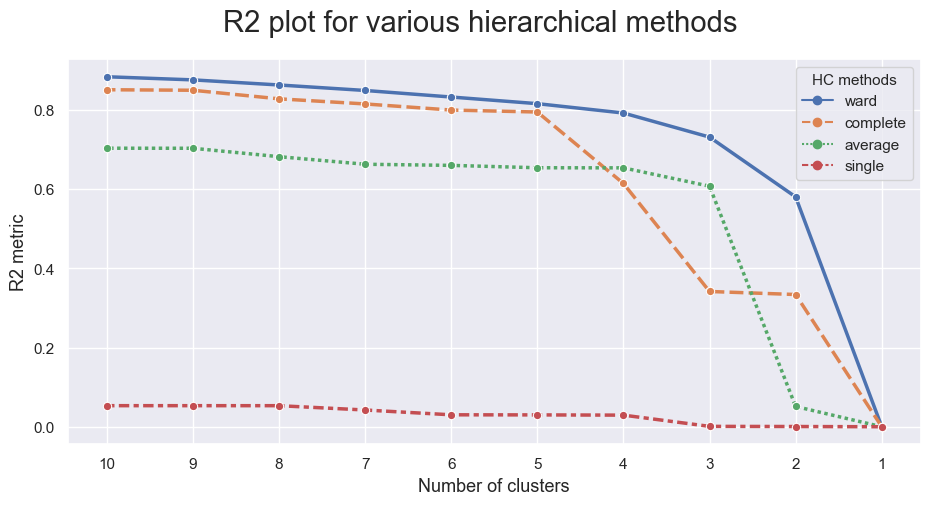

In [12]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df[metric_features], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

### Defining the number the clusters

In [13]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df[metric_features])

array([10399,  9073, 13493, ...,     6,     2,     0])

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizF

findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable'

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHatran-Regular.ttf', name='Noto Sans Hatran', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/AquaKana.ttc', name='.Aqua Kana', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCoptic-Regular.ttf', name='Noto Sans Coptic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gujarati Sangam MN.ttc', name='Gujarati Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMeroitic-Regular.ttf', name='Noto Sans Meroitic', style='normal', variant='normal', weight=400, stretch='norma

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kokonor.ttf', name='Kokonor', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLinearA-Regular.ttf', name='Noto Sans Linear A', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansManichaean-Regular.ttf', name='Noto Sans Manichaean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNewTaiLue-Regular.ttf', name='Noto Sans New Tai Lue', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Chalkboard.ttc', name='Chalkboard', style='normal', variant='normal', weight=400, stretch

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSaurashtra-Regular.ttf', name='Noto Sans Saurashtra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Corsiva.ttc', name='Corsiva Hebrew', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOlChiki-Regular.ttf', name='Noto Sans Ol Chiki', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldItalic-Regular.ttf', name='Noto Sans Old Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/ChalkboardSE.ttc', name='Chalkboard SE', style='normal', variant='normal', weight=4

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBuginese-Regular.ttf', name='Noto Sans Buginese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Raanana.ttc', name='Raanana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Comic Sans MS Bold.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Lao MN.ttc', name='Lao MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier New Bold.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
fi

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMiao-Regular.ttf', name='Noto Sans Miao', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/InaiMathi-MN.ttc', name='InaiMathi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Telugu MN.ttc', name='Telugu MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCarian-Regular.ttf', name='Noto Sans Carian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) 

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldNorthArabian-Regular.ttf', name='Noto Sans Old North Arabian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SnellRoundhand.ttc', name='Snell Roundhand', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizFiveSymReg.otf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNabataean-Regular.ttf', name='Noto Sans Nabataean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Kufi.ttc', name='Diwan Kufi', style='normal', variant='normal', we

findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W8.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Damascus.ttc', name='Damascus', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSylotiNagri-Regular.ttf', name='Noto Sans Syloti Nagri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Cochin.ttc', name='Cochin', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMarchen-Regular.ttf', name='Noto Sans Marchen', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.0

findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSMonoItalic.ttf', name='.SF NS Mono', style='italic', variant='normal', weight=295, stretch='normal', size='scalable')) = 11.14975
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMultani-Regular.ttf', name='Noto Sans Multani', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldPermic-Regular.ttf', name='Noto Sans Old Permic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Papyrus.ttc', name='Papyrus', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='sca

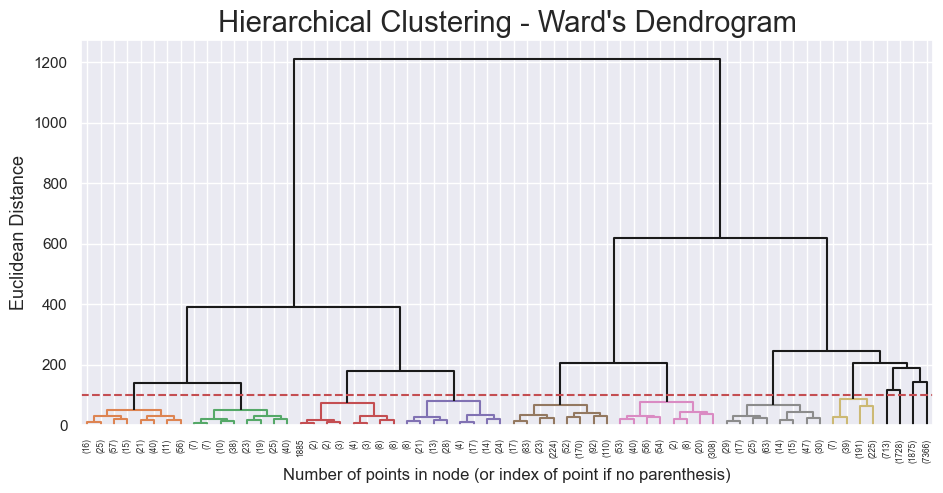

In [14]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [86]:
# 10 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc10lust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=10)
hc10_labels = hc10lust.fit_predict(df[metric_features])

In [87]:
# Characterizing the 10 clusters
df_concat = pd.concat((df, pd.Series(hc10_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,...,Dropout,Gender_binary,Athletics,Water,Fitness,Team,Racket,Combat,Special,Other
labels,,,,,,,,,,,,,,,,,,,,,
0,-0.481707,-0.065645,3.683389,2.375280,30.778049,-1.371545,-0.448862,0.316667,1.091463,0.119512,...,0.380488,0.570732,0.007317,0.863415,0.095122,0.112195,0.024390,0.014634,0.017073,0.000000
1,0.436352,-0.035772,0.083390,0.339397,0.025568,-0.009503,0.345425,0.272559,-0.111187,0.004209,...,0.910128,0.601683,0.008553,0.131958,0.774369,0.011404,0.001493,0.135487,0.015069,0.000136
2,1.602633,-0.377118,2.696497,5.797180,0.269841,0.000000,0.419164,2.155844,1.005411,0.019481,...,0.305195,0.415584,0.015152,0.270563,0.642857,0.036797,0.000000,0.090909,0.164502,0.000000
3,-0.187526,0.348791,0.184808,-0.129488,2.188994,-1.652601,-0.501169,-0.098389,-0.123515,0.035231,...,0.680868,0.614912,0.006555,0.534617,0.219172,0.156903,0.083163,0.048341,0.039738,0.007784
4,0.302489,2.355672,-0.031674,-0.022804,0.013333,-0.004267,0.136002,-0.089422,0.094933,0.004800,...,0.910400,0.638400,0.006933,0.129067,0.744000,0.012267,0.002133,0.153067,0.008000,0.000000
5,-0.329550,0.162646,1.212762,0.484243,9.672719,-1.457847,-0.485779,0.050584,0.289883,0.055772,...,0.732815,0.588846,0.000000,0.706874,0.099870,0.143969,0.084306,0.036316,0.022049,0.002594
6,-0.442237,0.288144,2.278902,1.386571,17.697474,-1.329636,-0.435663,0.241220,0.680222,0.053604,...,0.580407,0.567468,0.001848,0.800370,0.105360,0.116451,0.051756,0.025878,0.022181,0.000000
7,-0.094961,-0.183056,4.565680,4.194846,51.576227,-1.253230,-0.334504,0.739018,1.391473,0.186047,...,0.333333,0.558140,0.000000,0.813953,0.162791,0.046512,0.038760,0.031008,0.031008,0.000000
8,0.411290,-0.221198,5.343935,5.924150,77.032258,-1.268817,-0.373165,1.284946,1.580645,0.096774,...,0.161290,0.419355,0.000000,0.870968,0.129032,0.129032,0.000000,0.064516,0.032258,0.000000


In [88]:
# 11 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc11lust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=11)
hc11_labels = hc11lust.fit_predict(df[metric_features])

In [89]:
# Characterizing the 11 clusters
df_concat = pd.concat((df, pd.Series(hc11_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,...,Dropout,Gender_binary,Athletics,Water,Fitness,Team,Racket,Combat,Special,Other
labels,,,,,,,,,,,,,,,,,,,,,
0,0.436352,-0.035772,0.083390,0.339397,0.025568,-0.009503,0.345425,0.272559,-0.111187,0.004209,...,0.910128,0.601683,0.008553,0.131958,0.774369,0.011404,0.001493,0.135487,0.015069,0.000136
1,-0.187526,0.348791,0.184808,-0.129488,2.188994,-1.652601,-0.501169,-0.098389,-0.123515,0.035231,...,0.680868,0.614912,0.006555,0.534617,0.219172,0.156903,0.083163,0.048341,0.039738,0.007784
2,1.602633,-0.377118,2.696497,5.797180,0.269841,0.000000,0.419164,2.155844,1.005411,0.019481,...,0.305195,0.415584,0.015152,0.270563,0.642857,0.036797,0.000000,0.090909,0.164502,0.000000
3,-0.094961,-0.183056,4.565680,4.194846,51.576227,-1.253230,-0.334504,0.739018,1.391473,0.186047,...,0.333333,0.558140,0.000000,0.813953,0.162791,0.046512,0.038760,0.031008,0.031008,0.000000
4,0.302489,2.355672,-0.031674,-0.022804,0.013333,-0.004267,0.136002,-0.089422,0.094933,0.004800,...,0.910400,0.638400,0.006933,0.129067,0.744000,0.012267,0.002133,0.153067,0.008000,0.000000
5,-0.329550,0.162646,1.212762,0.484243,9.672719,-1.457847,-0.485779,0.050584,0.289883,0.055772,...,0.732815,0.588846,0.000000,0.706874,0.099870,0.143969,0.084306,0.036316,0.022049,0.002594
6,-0.442237,0.288144,2.278902,1.386571,17.697474,-1.329636,-0.435663,0.241220,0.680222,0.053604,...,0.580407,0.567468,0.001848,0.800370,0.105360,0.116451,0.051756,0.025878,0.022181,0.000000
7,-0.455621,-0.160440,4.192899,2.932832,36.528600,-1.284024,-0.410279,0.399408,1.183432,0.142012,...,0.307692,0.585799,0.017751,0.881657,0.100592,0.136095,0.017751,0.017751,0.029586,0.000000
8,0.411290,-0.221198,5.343935,5.924150,77.032258,-1.268817,-0.373165,1.284946,1.580645,0.096774,...,0.161290,0.419355,0.000000,0.870968,0.129032,0.129032,0.000000,0.064516,0.032258,0.000000


In [90]:
df_hc11_hc10 = pd.concat((df,
                        pd.Series(hc11_labels,
                                  name='hc11_labels',
                                  index=df.index),
                        pd.Series(hc10_labels,
                                  name='hc10_labels',
                                  index=df.index)
                        ), axis=1)

In [91]:
pd.crosstab(df_hc11_hc10['hc11_labels'],
           df_hc11_hc10['hc10_labels'])

hc10_labels,0,1,2,3,4,5,6,7,8,9
hc11_labels,,,,,,,,,,
0,0,7366,0,0,0,0,0,0,0,0
1,0,0,0,2441,0,0,0,0,0,0
2,0,0,462,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,129,0,0
4,0,0,0,0,1875,0,0,0,0,0
5,0,0,0,0,0,771,0,0,0,0
6,0,0,0,0,0,0,541,0,0,0
7,169,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,31,0


In [92]:
# final cluster solution
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=10)
hc_labels = hclust.fit_predict(df[metric_features])

In [93]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(hc_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,...,Dropout,Gender_binary,Athletics,Water,Fitness,Team,Racket,Combat,Special,Other
labels,,,,,,,,,,,,,,,,,,,,,
0,-0.481707,-0.065645,3.683389,2.375280,30.778049,-1.371545,-0.448862,0.316667,1.091463,0.119512,...,0.380488,0.570732,0.007317,0.863415,0.095122,0.112195,0.024390,0.014634,0.017073,0.000000
1,0.436352,-0.035772,0.083390,0.339397,0.025568,-0.009503,0.345425,0.272559,-0.111187,0.004209,...,0.910128,0.601683,0.008553,0.131958,0.774369,0.011404,0.001493,0.135487,0.015069,0.000136
2,1.602633,-0.377118,2.696497,5.797180,0.269841,0.000000,0.419164,2.155844,1.005411,0.019481,...,0.305195,0.415584,0.015152,0.270563,0.642857,0.036797,0.000000,0.090909,0.164502,0.000000
3,-0.187526,0.348791,0.184808,-0.129488,2.188994,-1.652601,-0.501169,-0.098389,-0.123515,0.035231,...,0.680868,0.614912,0.006555,0.534617,0.219172,0.156903,0.083163,0.048341,0.039738,0.007784
4,0.302489,2.355672,-0.031674,-0.022804,0.013333,-0.004267,0.136002,-0.089422,0.094933,0.004800,...,0.910400,0.638400,0.006933,0.129067,0.744000,0.012267,0.002133,0.153067,0.008000,0.000000
5,-0.329550,0.162646,1.212762,0.484243,9.672719,-1.457847,-0.485779,0.050584,0.289883,0.055772,...,0.732815,0.588846,0.000000,0.706874,0.099870,0.143969,0.084306,0.036316,0.022049,0.002594
6,-0.442237,0.288144,2.278902,1.386571,17.697474,-1.329636,-0.435663,0.241220,0.680222,0.053604,...,0.580407,0.567468,0.001848,0.800370,0.105360,0.116451,0.051756,0.025878,0.022181,0.000000
7,-0.094961,-0.183056,4.565680,4.194846,51.576227,-1.253230,-0.334504,0.739018,1.391473,0.186047,...,0.333333,0.558140,0.000000,0.813953,0.162791,0.046512,0.038760,0.031008,0.031008,0.000000
8,0.411290,-0.221198,5.343935,5.924150,77.032258,-1.268817,-0.373165,1.284946,1.580645,0.096774,...,0.161290,0.419355,0.000000,0.870968,0.129032,0.129032,0.000000,0.064516,0.032258,0.000000


In [94]:
cluster_means = df_concat.groupby('labels').mean()[metric_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

labels,0,1,2,3,4,5,6,7,8,9
Age,-0.48,0.44,1.60,-0.19,0.30,-0.33,-0.44,-0.09,0.41,0.27
DaysWithoutFrequency,-0.07,-0.04,-0.38,0.35,2.36,0.16,0.29,-0.18,-0.22,11.44
LifetimeValue,3.68,0.08,2.70,0.18,-0.03,1.21,2.28,4.57,5.34,0.67
NumberOfFrequencies,2.38,0.34,5.80,-0.13,-0.02,0.48,1.39,4.19,5.92,0.23
AttendedClasses,30.78,0.03,0.27,2.19,0.01,9.67,17.70,51.58,77.03,1.16
AllowedWeeklyVisits,-1.37,-0.01,0.00,-1.65,-0.00,-1.46,-1.33,-1.25,-1.27,-0.48
AllowedNVisits,-0.45,0.35,0.42,-0.50,0.14,-0.49,-0.44,-0.33,-0.37,0.03
NVisits,0.32,0.27,2.16,-0.10,-0.09,0.05,0.24,0.74,1.28,-0.13
NRenewals,1.09,-0.11,1.01,-0.12,0.09,0.29,0.68,1.39,1.58,1.09
NReferences,0.12,0.00,0.02,0.04,0.00,0.06,0.05,0.19,0.10,0.02


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=23.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSiz

findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable'

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHatran-Regular.ttf', name='Noto Sans Hatran', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/AquaKana.ttc', name='.Aqua Kana', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCoptic-Regular.ttf', name='Noto Sans Coptic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gujarati Sangam MN.ttc', name='Gujarati Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMeroitic-Regular.ttf', name='Noto Sans Meroitic', style='normal', variant='normal', weight=400, stretch='norma

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kokonor.ttf', name='Kokonor', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLinearA-Regular.ttf', name='Noto Sans Linear A', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansManichaean-Regular.ttf', name='Noto Sans Manichaean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNewTaiLue-Regular.ttf', name='Noto Sans New Tai Lue', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Chalkboard.ttc', name='Chalkboard', style='normal', variant='normal', weight=400, stretch

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSaurashtra-Regular.ttf', name='Noto Sans Saurashtra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Corsiva.ttc', name='Corsiva Hebrew', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOlChiki-Regular.ttf', name='Noto Sans Ol Chiki', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldItalic-Regular.ttf', name='Noto Sans Old Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/ChalkboardSE.ttc', name='Chalkboard SE', style='normal', variant='normal', weight=4

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBuginese-Regular.ttf', name='Noto Sans Buginese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Raanana.ttc', name='Raanana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Comic Sans MS Bold.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Lao MN.ttc', name='Lao MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier New Bold.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
fi

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMiao-Regular.ttf', name='Noto Sans Miao', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/InaiMathi-MN.ttc', name='InaiMathi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Telugu MN.ttc', name='Telugu MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCarian-Regular.ttf', name='Noto Sans Carian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) 

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldNorthArabian-Regular.ttf', name='Noto Sans Old North Arabian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SnellRoundhand.ttc', name='Snell Roundhand', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizFiveSymReg.otf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNabataean-Regular.ttf', name='Noto Sans Nabataean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Kufi.ttc', name='Diwan Kufi', style='normal', variant='normal', we

findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W8.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Damascus.ttc', name='Damascus', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSylotiNagri-Regular.ttf', name='Noto Sans Syloti Nagri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Cochin.ttc', name='Cochin', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMarchen-Regular.ttf', name='Noto Sans Marchen', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.0

findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSMonoItalic.ttf', name='.SF NS Mono', style='italic', variant='normal', weight=295, stretch='normal', size='scalable')) = 11.14975
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMultani-Regular.ttf', name='Noto Sans Multani', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldPermic-Regular.ttf', name='Noto Sans Old Permic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Papyrus.ttc', name='Papyrus', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='sca

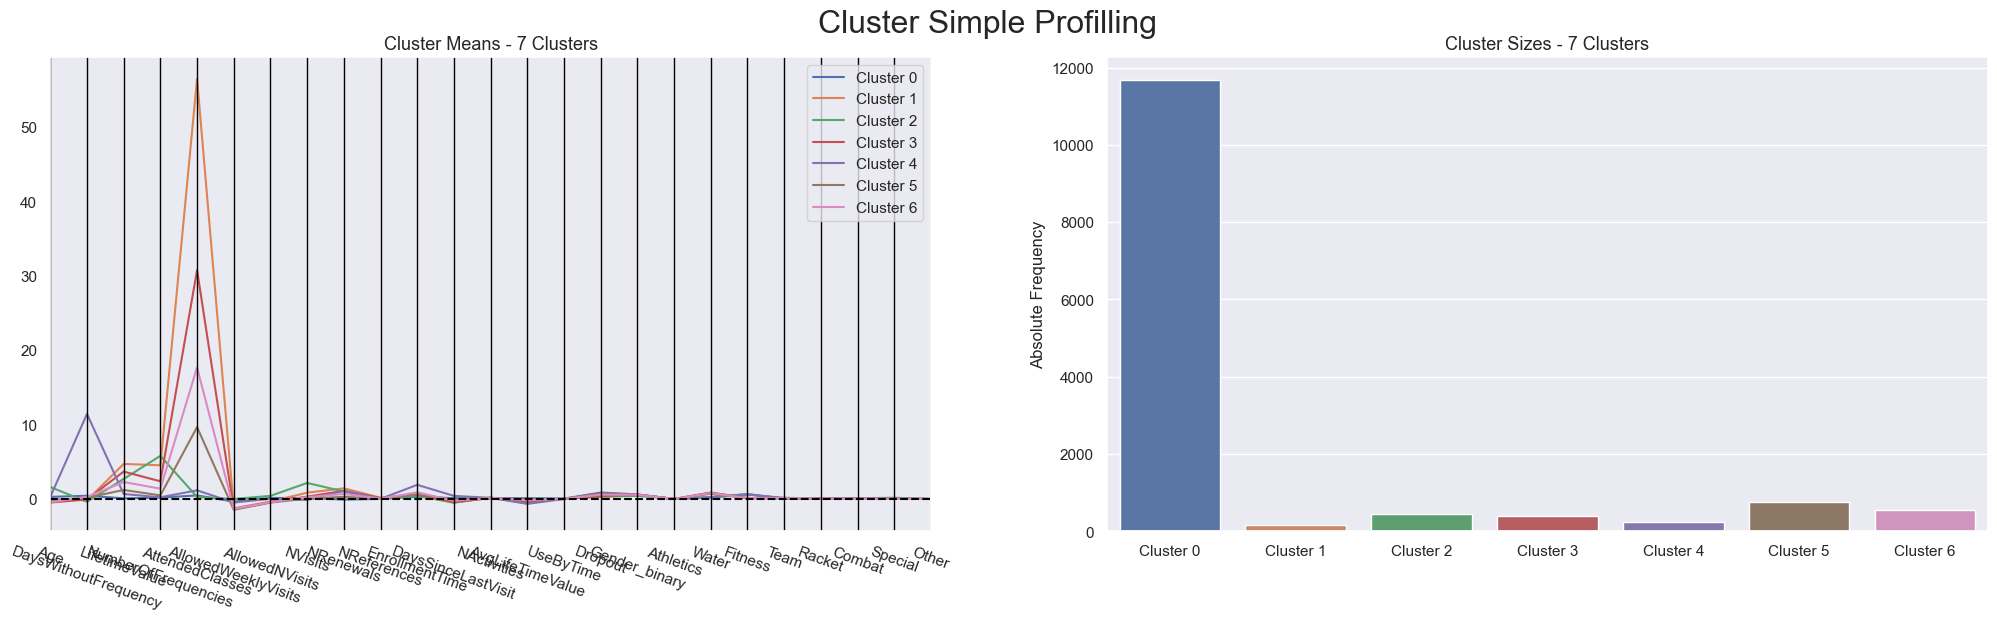

In [24]:
cluster_profiles(df_concat, ['labels'], (25,6))

In [95]:
hierarchical_silhouette_score = silhouette_score(df_concat, hclust.labels_)
hierarchical_silhouette_score

0.3092948851090158

In [96]:
hierarchical_db_index = davies_bouldin_score(df_concat, hclust.labels_)
hierarchical_db_index

1.0094352504473383

# K-means

In [27]:
df1 = data.copy()

In [28]:
range_clusters = range(1, 16)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df1)
    inertia.append(kmclust.inertia_) 

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSiz

findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable'

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHatran-Regular.ttf', name='Noto Sans Hatran', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/AquaKana.ttc', name='.Aqua Kana', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCoptic-Regular.ttf', name='Noto Sans Coptic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gujarati Sangam MN.ttc', name='Gujarati Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMeroitic-Regular.ttf', name='Noto Sans Meroitic', style='normal', variant='normal', weight=400, stretch='norma

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kokonor.ttf', name='Kokonor', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLinearA-Regular.ttf', name='Noto Sans Linear A', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansManichaean-Regular.ttf', name='Noto Sans Manichaean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNewTaiLue-Regular.ttf', name='Noto Sans New Tai Lue', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Chalkboard.ttc', name='Chalkboard', style='normal', variant='normal', weight=400, stretch

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSaurashtra-Regular.ttf', name='Noto Sans Saurashtra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Corsiva.ttc', name='Corsiva Hebrew', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOlChiki-Regular.ttf', name='Noto Sans Ol Chiki', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldItalic-Regular.ttf', name='Noto Sans Old Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/ChalkboardSE.ttc', name='Chalkboard SE', style='normal', variant='normal', weight=4

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBuginese-Regular.ttf', name='Noto Sans Buginese', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Raanana.ttc', name='Raanana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Comic Sans MS Bold.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Lao MN.ttc', name='Lao MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier New Bold.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
fi

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMiao-Regular.ttf', name='Noto Sans Miao', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/InaiMathi-MN.ttc', name='InaiMathi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Telugu MN.ttc', name='Telugu MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCarian-Regular.ttf', name='Noto Sans Carian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) 

findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldNorthArabian-Regular.ttf', name='Noto Sans Old North Arabian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SnellRoundhand.ttc', name='Snell Roundhand', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizFiveSymReg.otf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNabataean-Regular.ttf', name='Noto Sans Nabataean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Kufi.ttc', name='Diwan Kufi', style='normal', variant='normal', we

findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W8.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Damascus.ttc', name='Damascus', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSylotiNagri-Regular.ttf', name='Noto Sans Syloti Nagri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Cochin.ttc', name='Cochin', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMarchen-Regular.ttf', name='Noto Sans Marchen', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.0

findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSMonoItalic.ttf', name='.SF NS Mono', style='italic', variant='normal', weight=295, stretch='normal', size='scalable')) = 11.14975
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMultani-Regular.ttf', name='Noto Sans Multani', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldPermic-Regular.ttf', name='Noto Sans Old Permic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Papyrus.ttc', name='Papyrus', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='sca

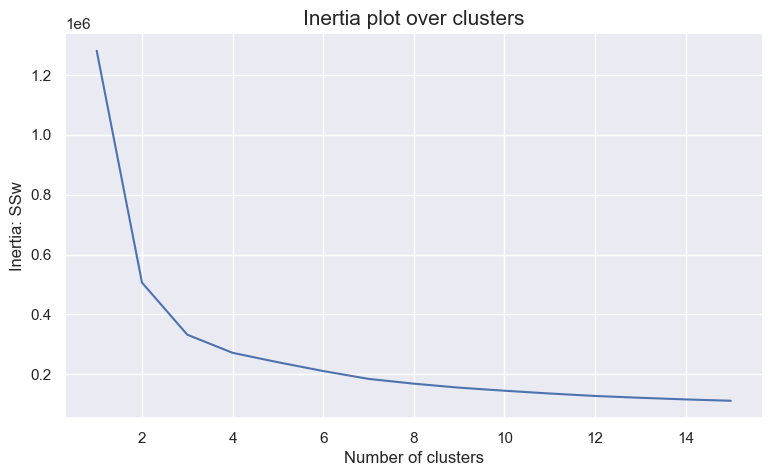

In [29]:
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.7741603848174787
For n_clusters = 3, the average silhouette_score is : 0.6812568073385035
For n_clusters = 4, the average silhouette_score is : 0.5779658018531337
For n_clusters = 5, the average silhouette_score is : 0.4647448166821821
For n_clusters = 6, the average silhouette_score is : 0.47757718704133595
For n_clusters = 7, the average silhouette_score is : 0.41977712489662145
For n_clusters = 8, the average silhouette_score is : 0.41094232471693576
For n_clusters = 9, the average silhouette_score is : 0.26984476870831875
For n_clusters = 10, the average silhouette_score is : 0.2678529517220277
For n_clusters = 11, the average silhouette_score is : 0.24657195914448332
For n_clusters = 12, the average silhouette_score is : 0.24849298730090844
For n_clusters = 13, the average silhouette_score is : 0.24044129457641086
For n_clusters = 14, the average silhouette_score is : 0.24150869215022858
For n_clusters = 15, the average silho

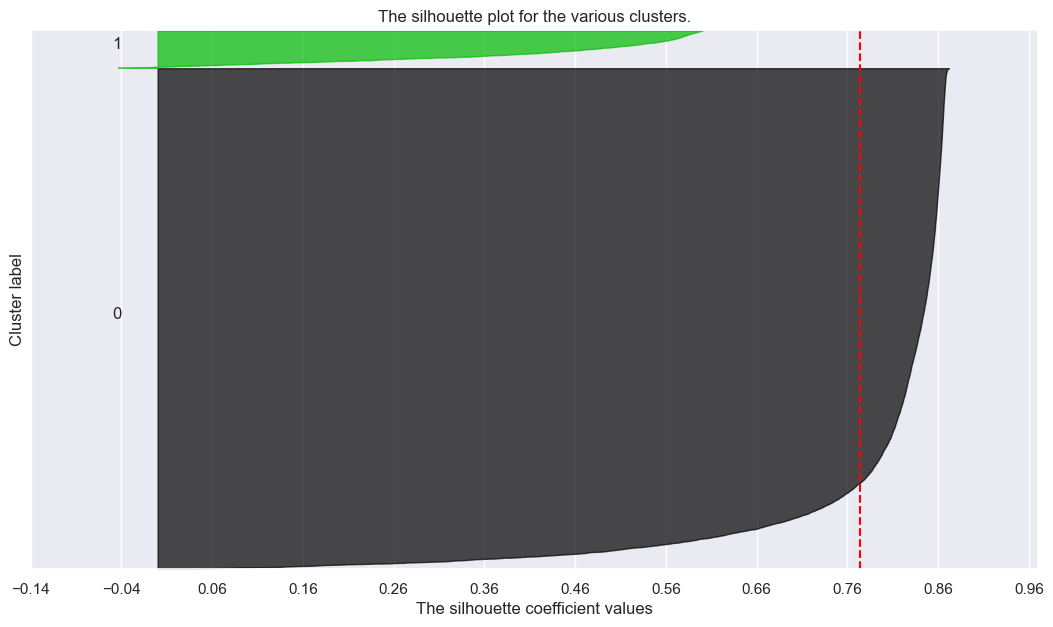

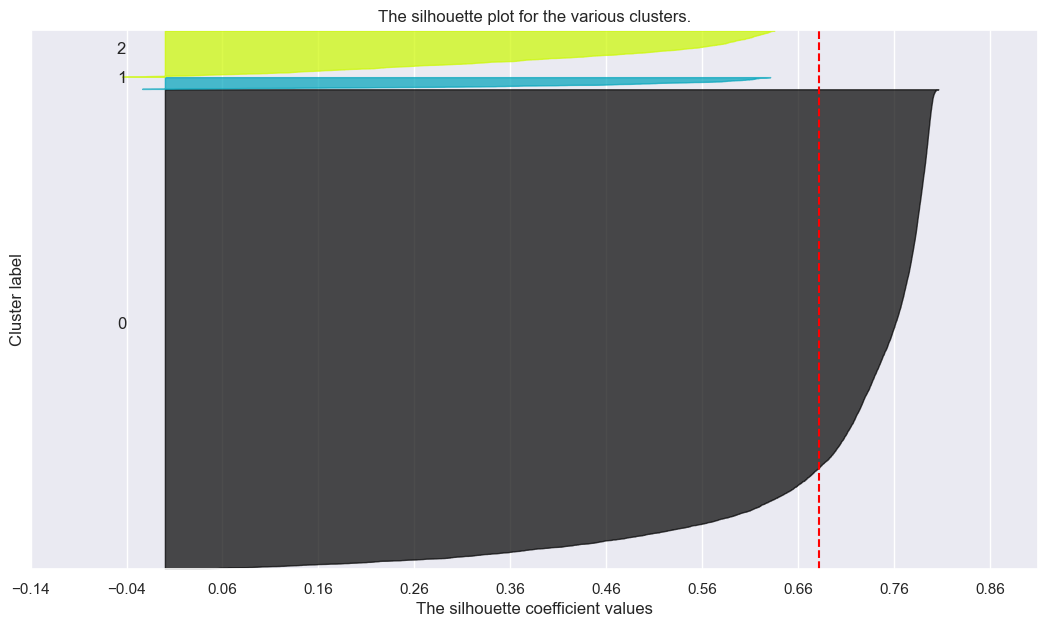

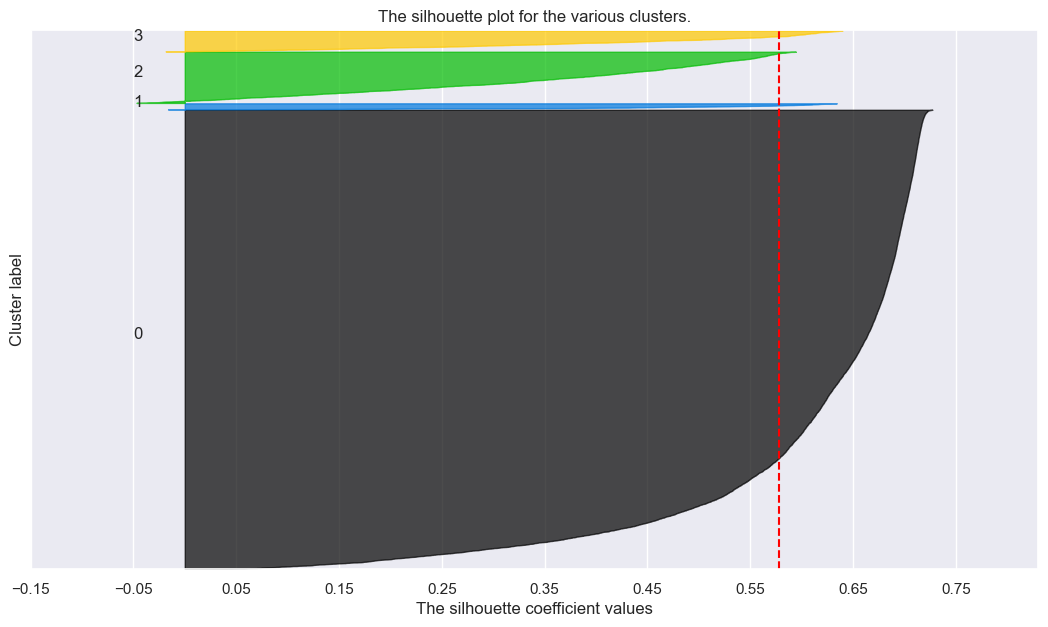

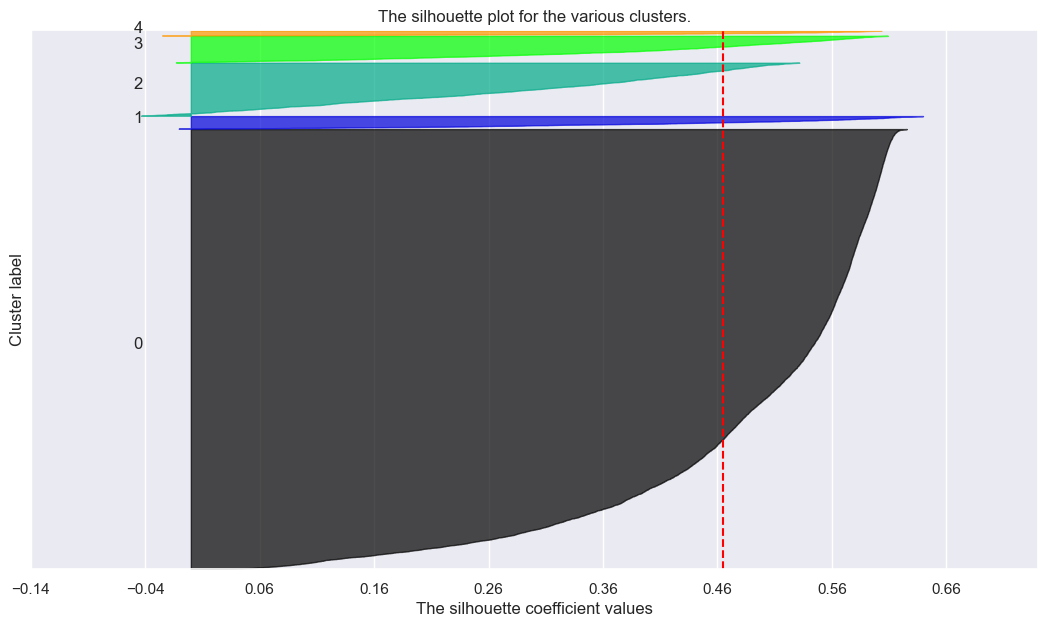

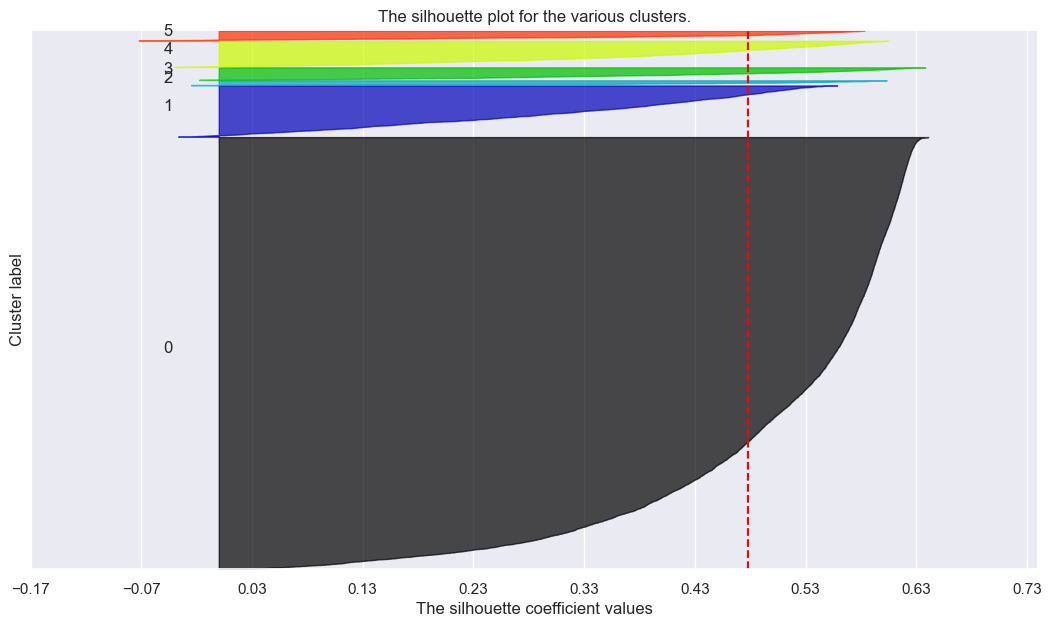

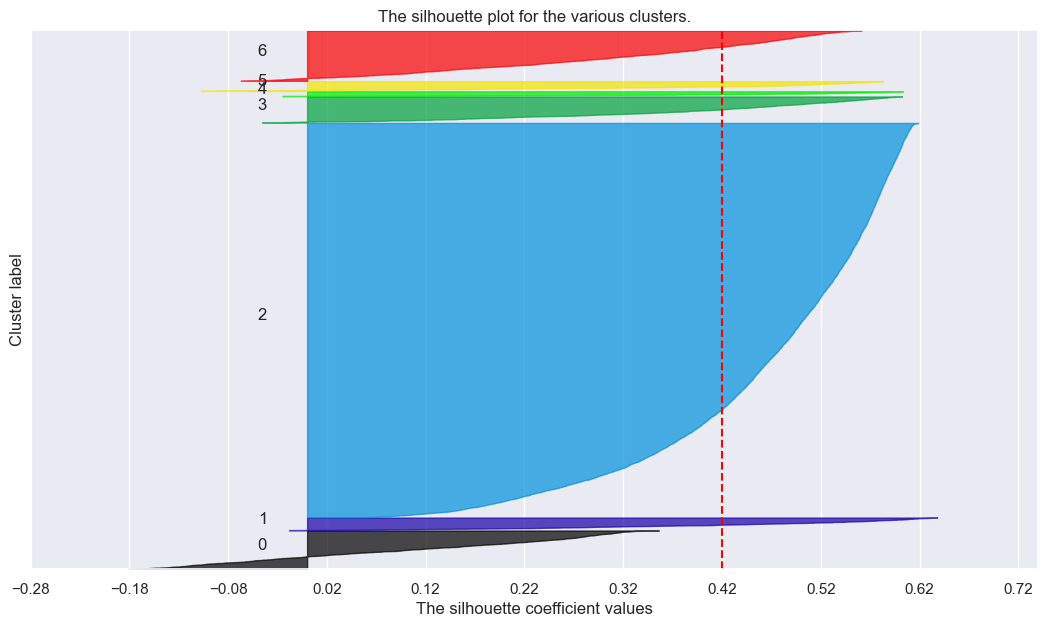

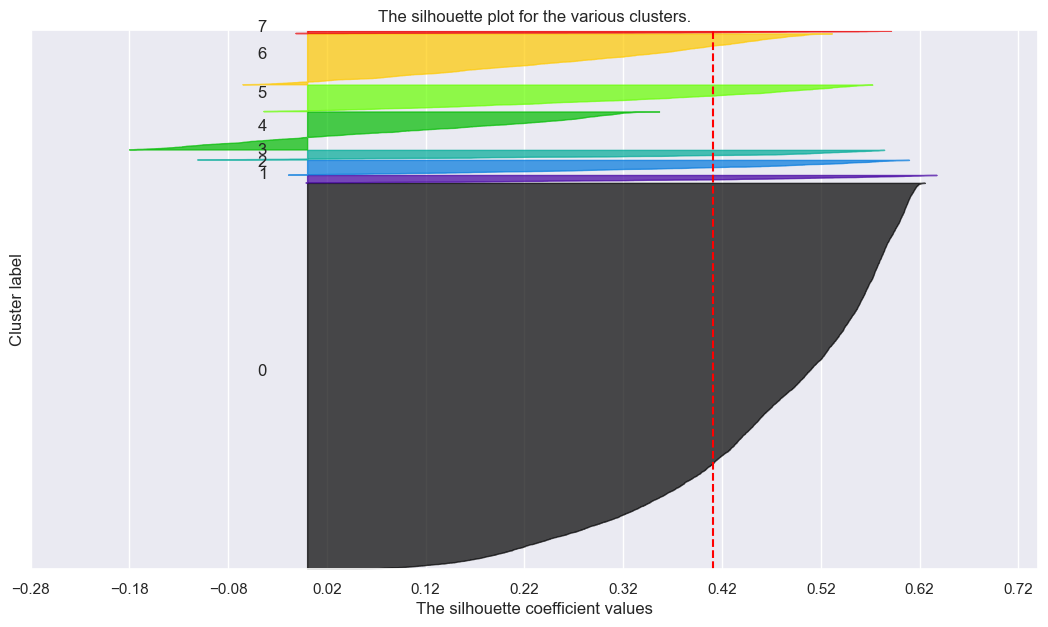

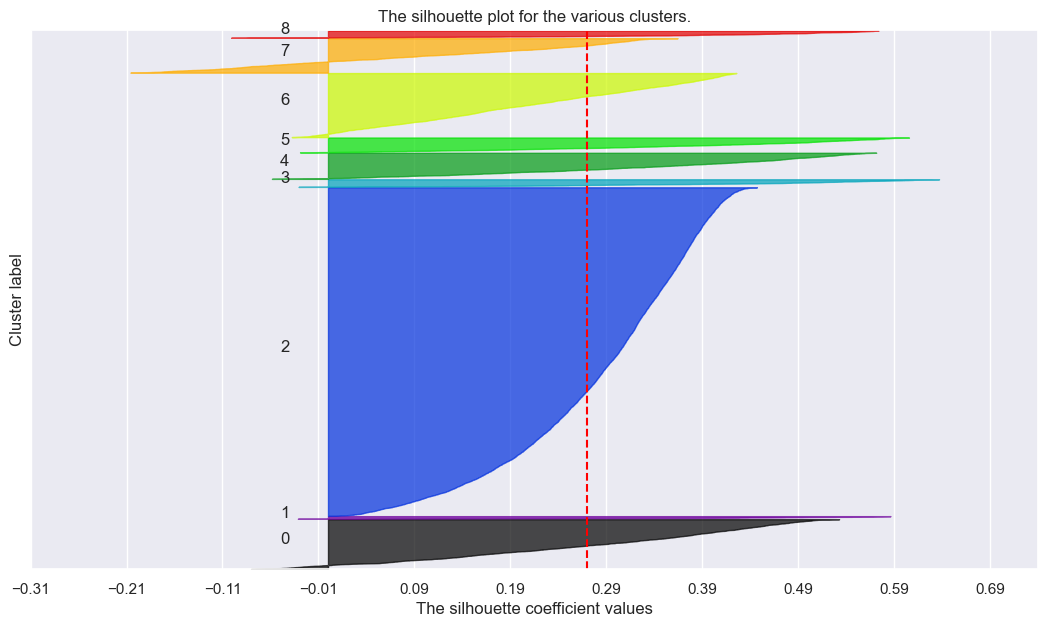

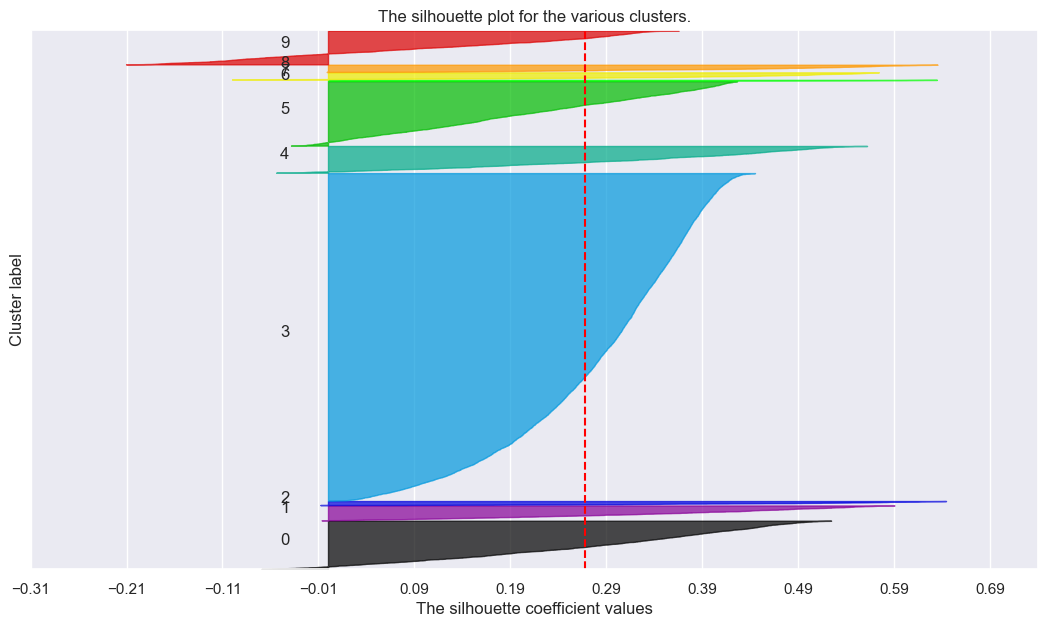

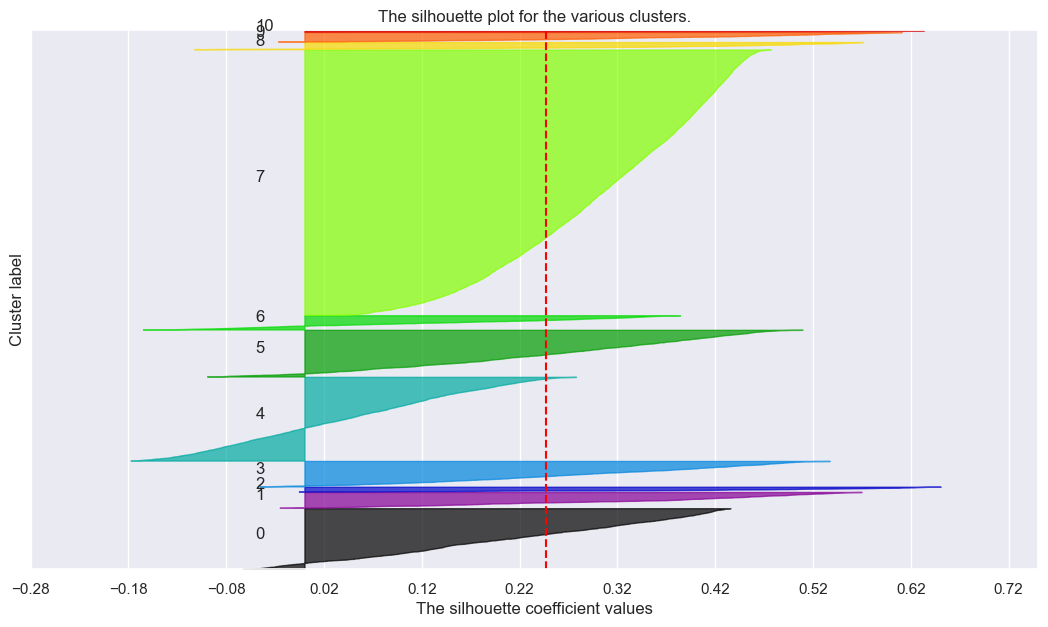

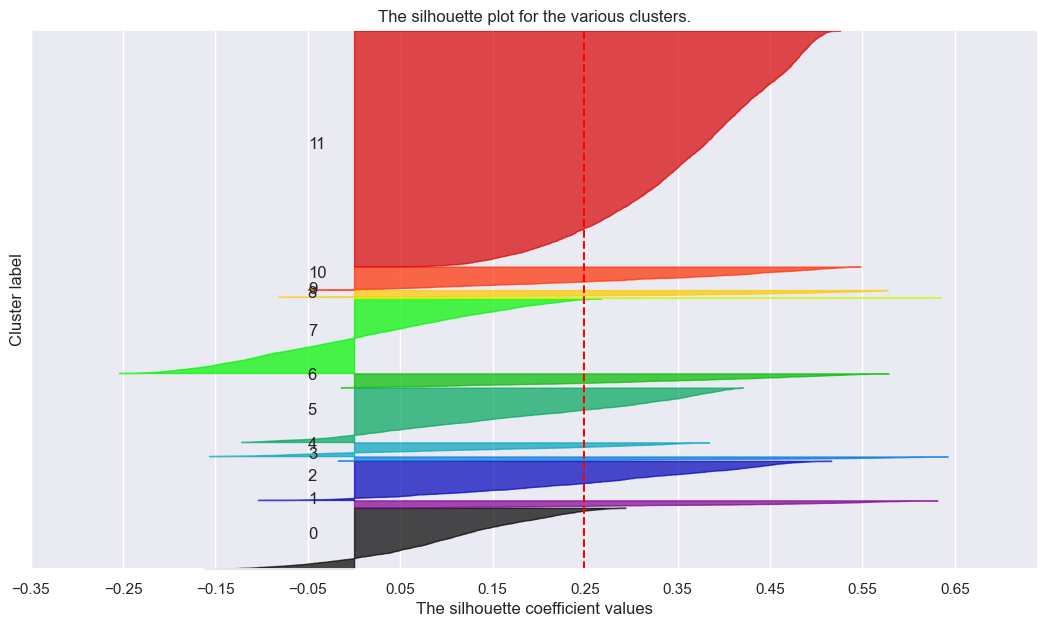

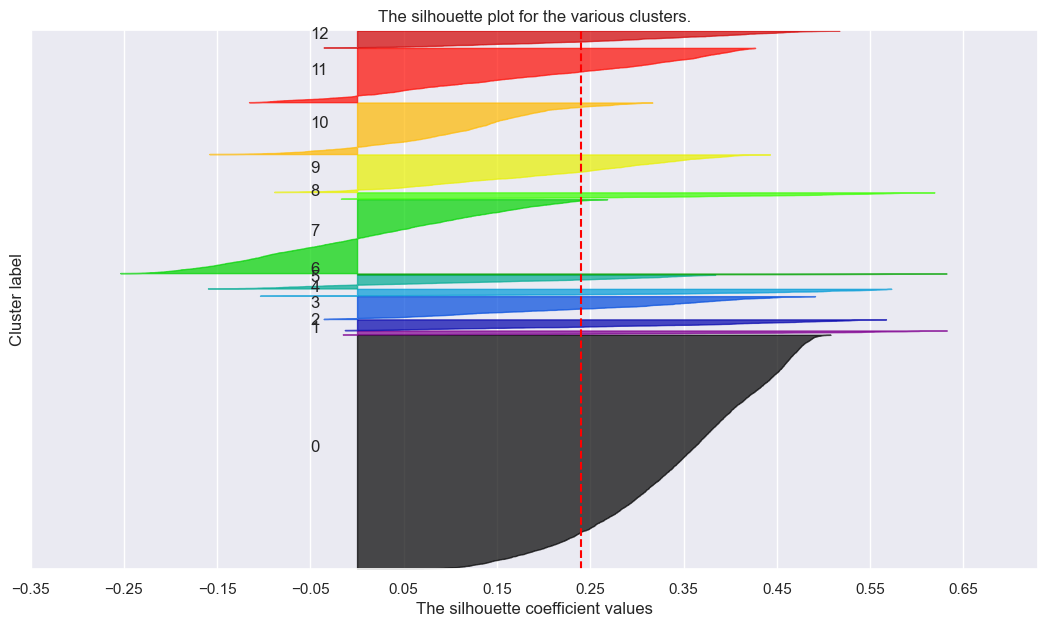

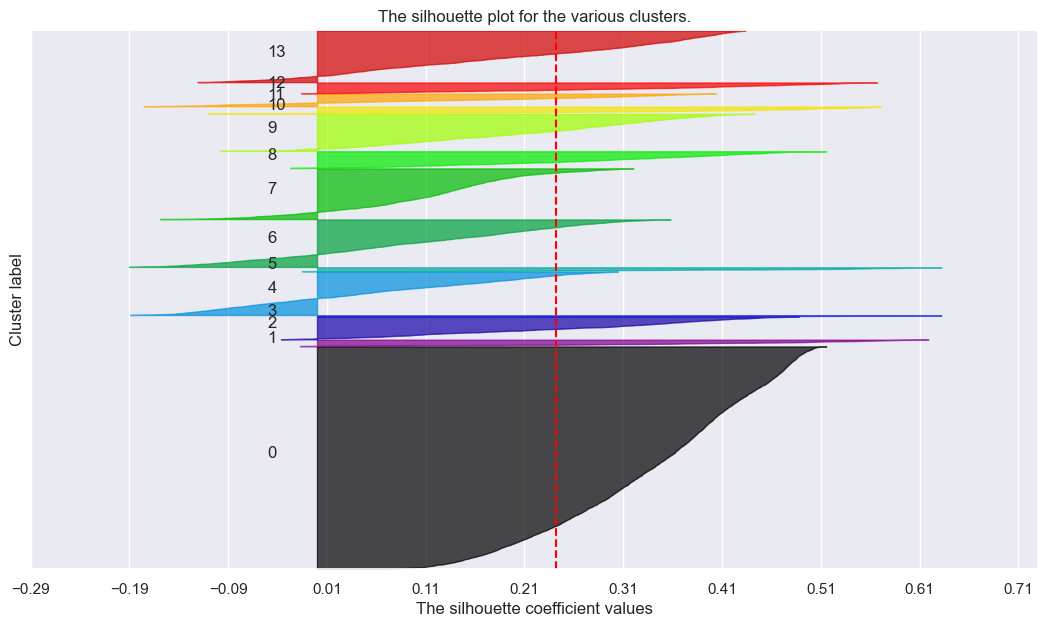

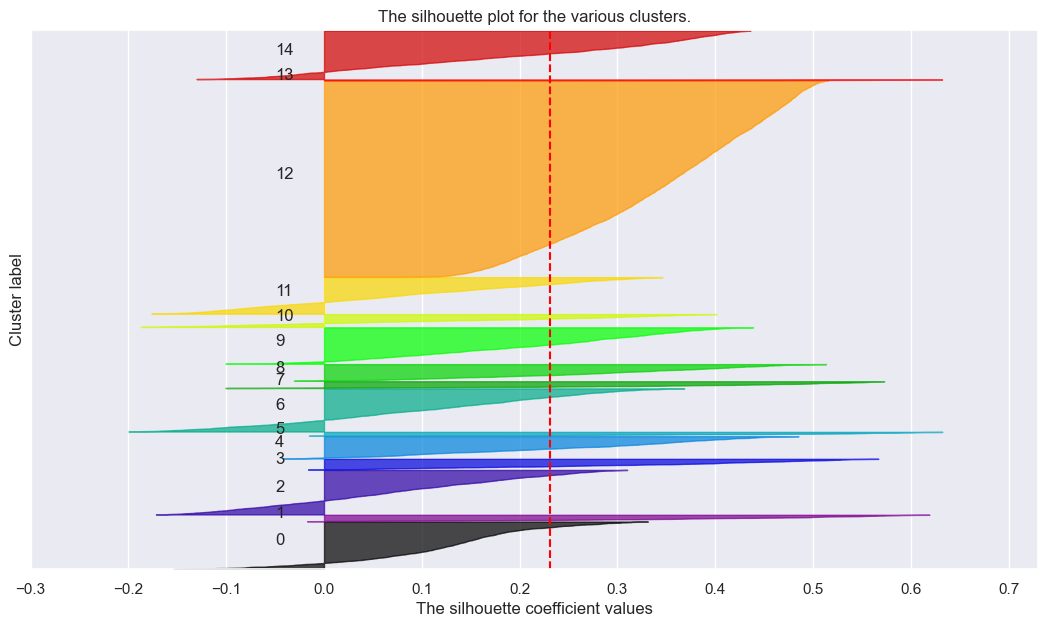

In [30]:
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df1, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df1, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df1) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

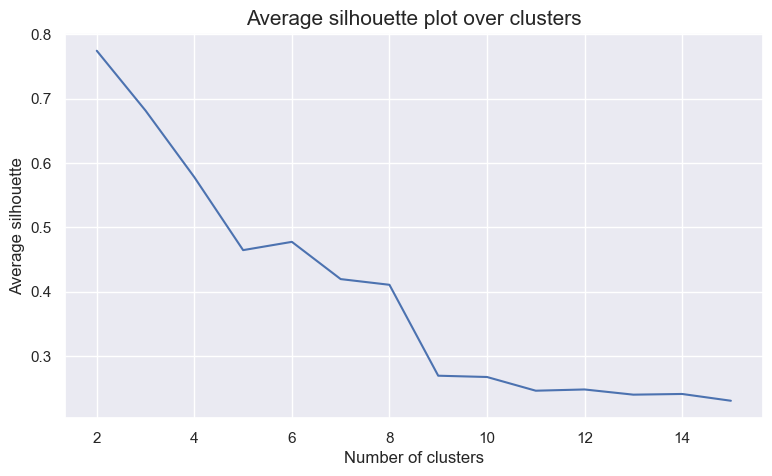

In [31]:
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [59]:
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df1)
km_labels

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

In [60]:
df_concat = pd.concat((df1, pd.Series(km_labels, name='labels', index=df1.index)), axis=1)
df_concat.groupby('labels').mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,...,Dropout,Gender_binary,Athletics,Water,Fitness,Team,Racket,Combat,Special,Other
labels,,,,,,,,,,,,,,,,,,,,,
0,0.287575,0.586302,0.272606,0.408531,1.141742,-0.414659,0.101996,0.199423,0.007831,0.014232,...,0.830648,0.601657,0.007605,0.251958,0.614684,0.050602,0.022440,0.113253,0.024398,0.001657
1,-0.386579,0.013474,3.271085,2.302862,29.909060,-1.346518,-0.432716,0.355477,0.961460,0.100406,...,0.443205,0.560852,0.003043,0.826572,0.108519,0.103448,0.040568,0.024341,0.019270,0.000000


In [61]:
n_clusters_kmeans = 2
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
kmeans_labels = kmeans.fit_predict(df1)

# Add the K-means labels to the DataFrame
df_concat['KMeans_Cluster'] = kmeans_labels

# Visualize K-means clusters
#sns.pairplot(df_concat, hue='KMeans_Cluster', palette='viridis', diag_kind='kde')
#plt.suptitle('Pairplot of K-means Clusters on Principal Components')
#plt.show()

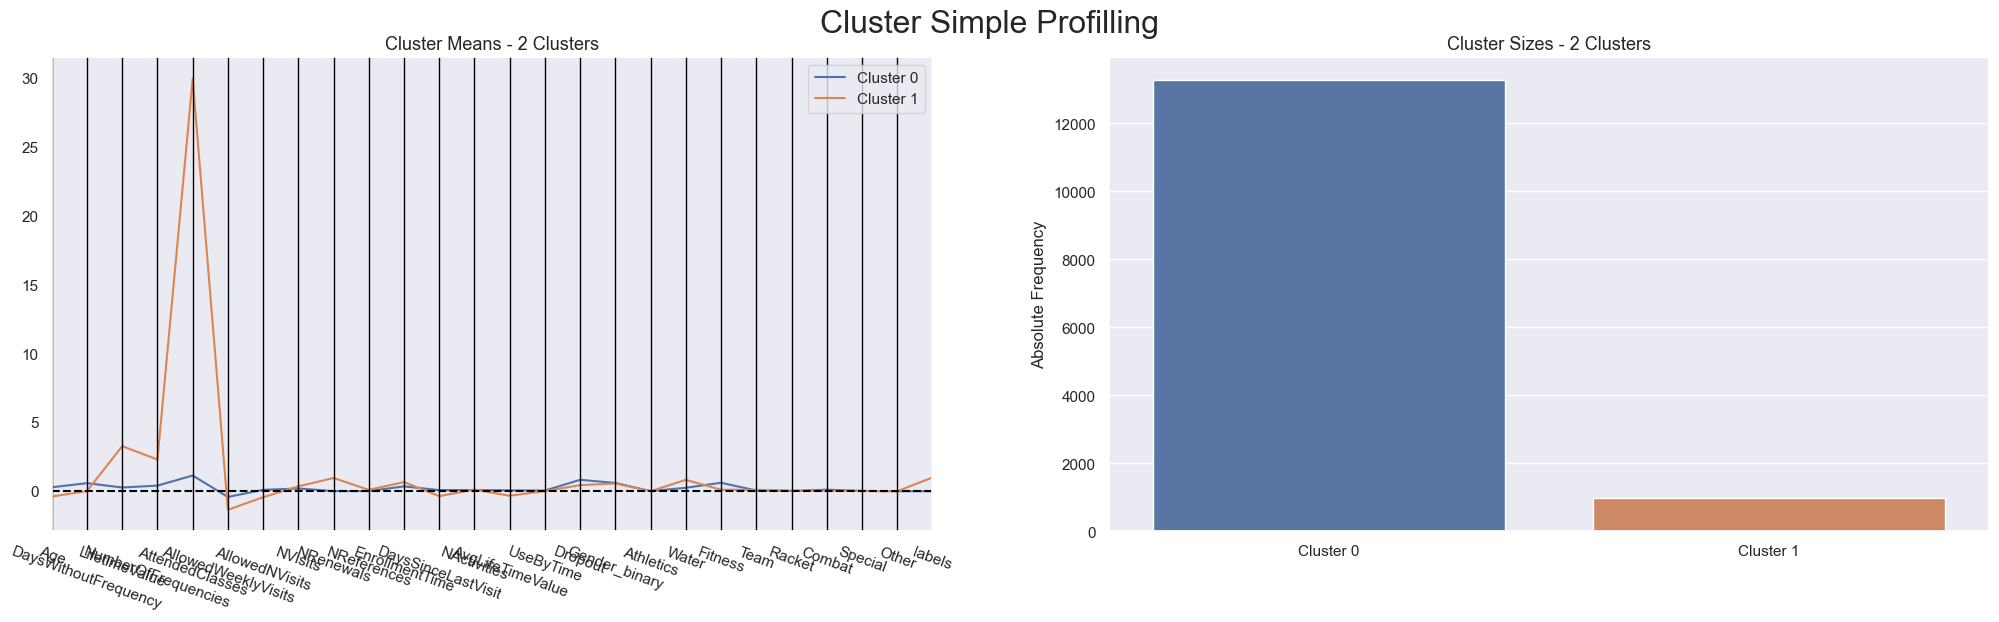

In [62]:
cluster_profiles(df_concat, ['KMeans_Cluster'], (25,6))

In [70]:
df_concat.groupby('KMeans_Cluster')[metric_features].mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,EnrollmentTime,DaysSinceLastVisit,NActivities,AvgLifeTimeValue
KMeans_Cluster,,,,,,,,,,,,,,
0,0.287575,0.586302,0.272606,0.408531,1.141742,-0.414659,0.101996,0.199423,0.007831,0.014232,0.353299,0.082617,0.086596,0.061813
1,-0.386579,0.013474,3.271085,2.302862,29.909060,-1.346518,-0.432716,0.355477,0.961460,0.100406,0.664885,-0.357602,0.125761,-0.329117


In [64]:
kmeans_silhouette_score = silhouette_score(df_concat[metric_features], kmeans.labels_)
round(kmeans_silhouette_score,3)

0.781

In [65]:
kmeans_db_index = davies_bouldin_score(df_concat[metric_features], kmeans.labels_)
round(kmeans_db_index,3)

0.534

# K-prototypes

In [128]:
from kmodes.kprototypes import KPrototypes

In [152]:
df_prototypes = data.copy()

In [122]:
array = df_prototypes.to_numpy() #convert to numpy array
array

array([[ 3.08333333, -0.57142857, -0.28297178, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5       ,  0.27142857,  1.21386063, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        , -0.48571429, -0.48166635, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.25      , -0.55714286, -0.4586293 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.66666667, -0.54285714,  2.40180457, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.75      , -0.38571429,  2.90478019, ...,  0.        ,
         0.        ,  0.        ]])

In [124]:
minmax = list()
for i in range(array.shape[1]):
    col_values = array[:, i]
    value_min = min(col_values)
    value_max = max(col_values)
    minmax.append([value_min, value_max])
print(minmax)

[[-1.9166666666666667, 4.75], [-0.5857142857142857, 19.3], [-0.626031867920906, 8.61508926857362], [-0.4594594594594595, 19.37837837837838], [0.0, 100.0], [-2.333333333333333, 0.0], [-1.092614969080958, 1.6200156372165757], [-0.6666666666666666, 9.0], [-0.5, 2.0], [0.0, 3.0], [-0.5662251655629139, 5.02317880794702], [-0.6244302643573382, 1.1494986326344576], [0.0, 2.0], [-0.950741505537826, 7.596095363243851], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]


In [125]:
for i in range(array.shape[1]):
    col_values = array[:, i]
    nan_count = np.count_nonzero(np.isnan(col_values))
    print('Column %d, Missing: %d' % (i, nan_count))


Column 0, Missing: 0
Column 1, Missing: 0
Column 2, Missing: 0
Column 3, Missing: 0
Column 4, Missing: 0
Column 5, Missing: 0
Column 6, Missing: 0
Column 7, Missing: 0
Column 8, Missing: 0
Column 9, Missing: 0
Column 10, Missing: 0
Column 11, Missing: 0
Column 12, Missing: 0
Column 13, Missing: 0
Column 14, Missing: 0
Column 15, Missing: 0
Column 16, Missing: 0
Column 17, Missing: 0
Column 18, Missing: 0
Column 19, Missing: 0
Column 20, Missing: 0
Column 21, Missing: 0
Column 22, Missing: 0
Column 23, Missing: 0
Column 24, Missing: 0


In [126]:
cat_cols_idx = [0, 1]

In [127]:
k_list = range(1,5)
cost = []
for k in k_list:
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', random_state = 0)
    kprototype.fit_predict(array, categorical = cat_cols_idx)
    cost.append(kprototype.cost_)

print(cost)

[1222203.8121951472, 448006.1333652603, 274254.6855343849, 213804.91165198924]


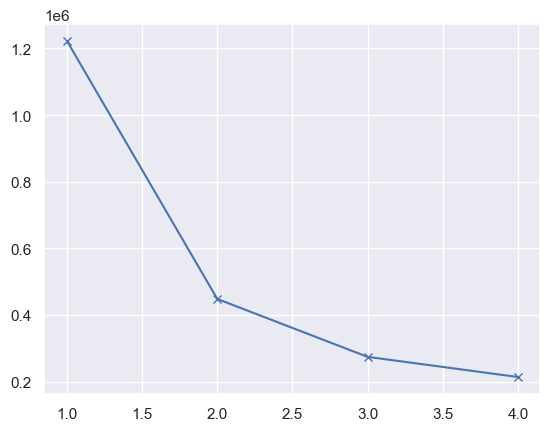

In [129]:
plt.plot(k_list, cost, 'bx-')

##### K = 2

In [151]:
k2 = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', random_state = 80)
k2_labels = k2.fit_predict(array, categorical = cat_cols_idx)

##### K = 3

In [131]:
k3 = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 80)
k3_labels = k3.fit_predict(array, categorical = cat_cols_idx)

In [136]:
df_concat = pd.concat([df_prototypes, pd.Series(k2_labels, name='k2_labels', index=df_prototypes.index), 
                     pd.Series(k3_labels, name='k3_labels', index=df_prototypes.index)], axis=1)

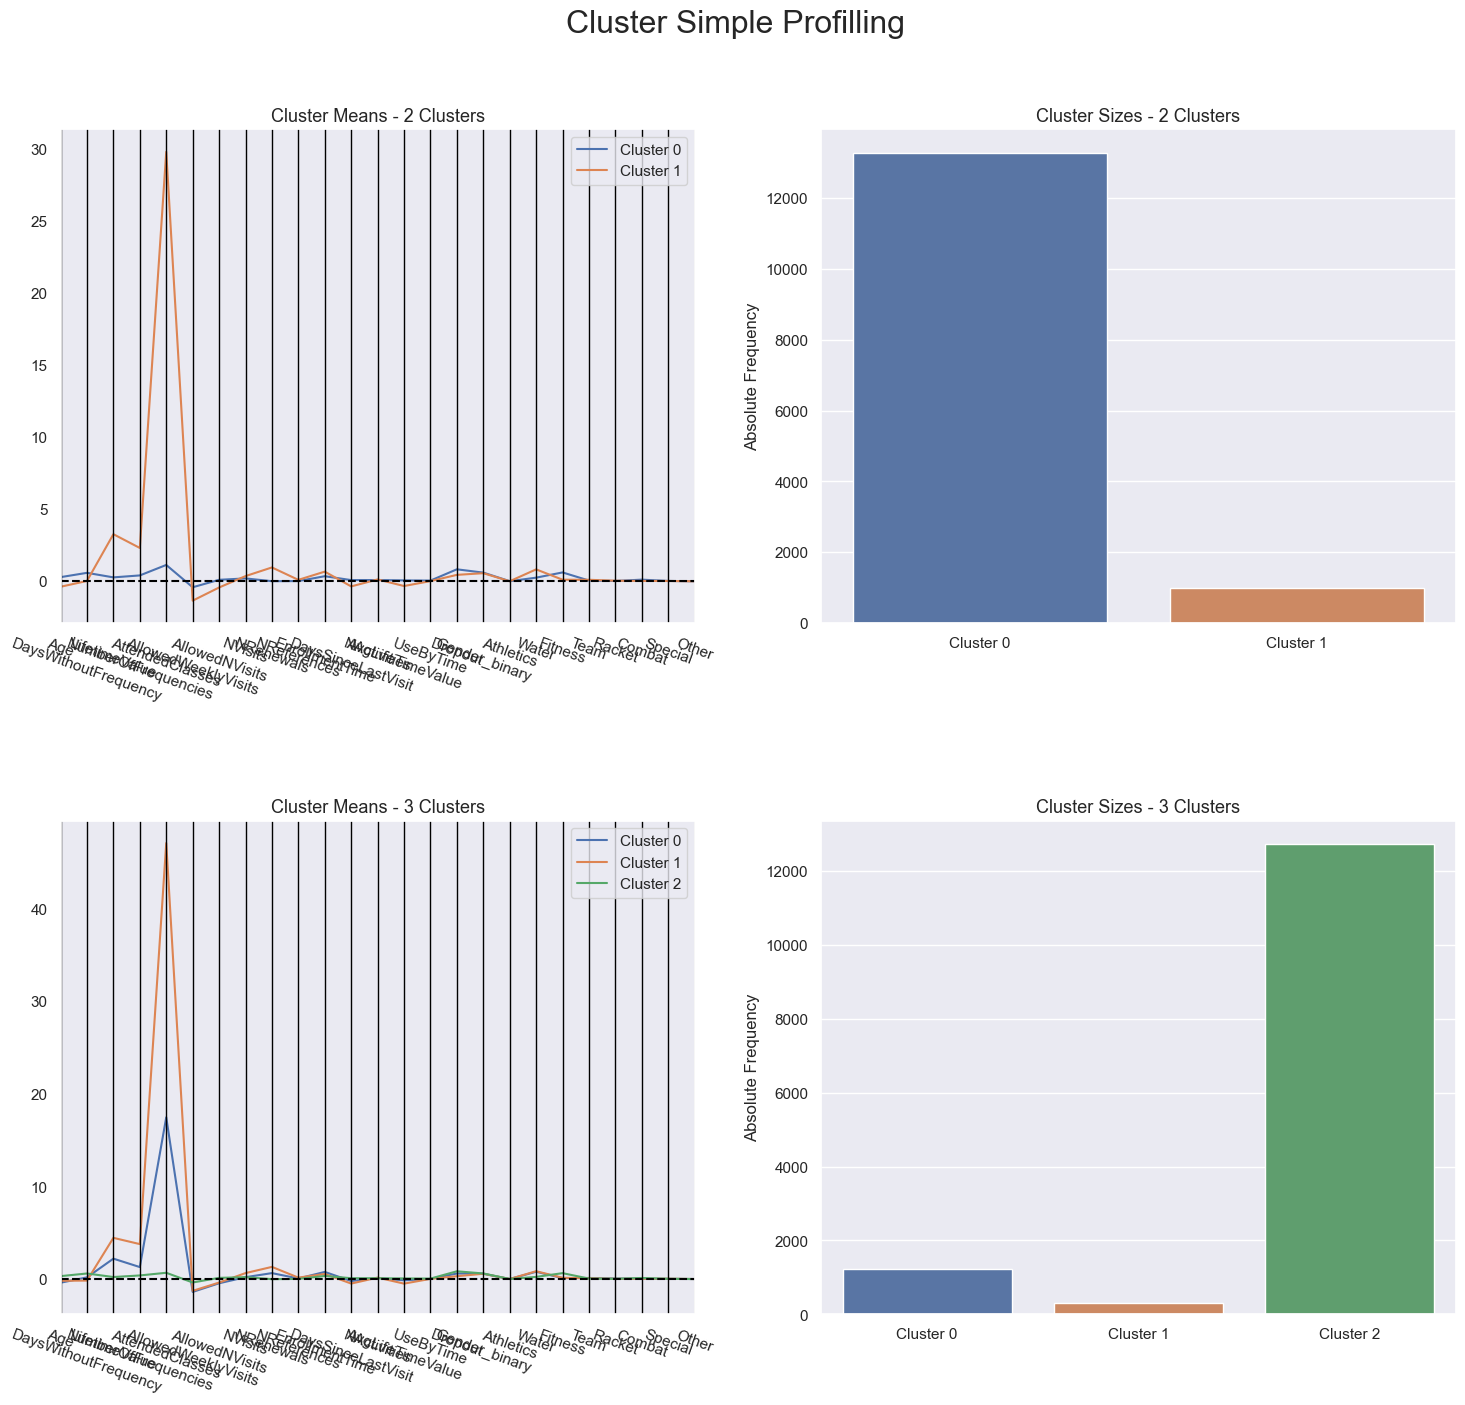

In [137]:
cluster_profiles(df_concat, ['k2_labels', 'k3_labels'], (18, 15))

In [143]:
df_concat.groupby('k2_labels')[metric_features].mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,EnrollmentTime,DaysSinceLastVisit,NActivities,AvgLifeTimeValue
k2_labels,,,,,,,,,,,,,,
0,0.287441,0.586004,0.271169,0.406764,1.133238,-0.414306,0.102217,0.199015,0.007309,0.014241,0.352749,0.082704,0.086423,0.061967
1,-0.379359,0.022061,3.266140,2.311219,29.791080,-1.343729,-0.431370,0.359658,0.960765,0.099598,0.669714,-0.355223,0.127767,-0.328017


In [145]:
df_concat.groupby('k3_labels')[metric_features].mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,EnrollmentTime,DaysSinceLastVisit,NActivities,AvgLifeTimeValue
k3_labels,,,,,,,,,,,,,,
0,-0.396259,0.179102,2.200406,1.291517,17.450340,-1.388844,-0.456396,0.200408,0.640000,0.061224,0.768047,-0.212508,0.111020,-0.138551
1,-0.189103,-0.166346,4.446028,3.770444,47.053419,-1.275641,-0.379963,0.641560,1.310897,0.153846,0.547642,-0.487986,0.157051,-0.495280
2,0.312849,0.599566,0.217050,0.387888,0.675256,-0.371985,0.126128,0.200579,-0.011077,0.012963,0.332757,0.090905,0.085553,0.064469


In [146]:
kprotorypes_silhouette_score = silhouette_score(df_concat[metric_features], k2_labels)
round(kmeans_silhouette_score,3)

0.781

In [139]:
kprotorypes_silhouette_score = silhouette_score(df_concat[metric_features], k3_labels)
round(kmeans_silhouette_score,3)

0.781

# SOM + K-MEANS

In [251]:
df2 = data.copy()

In [252]:
np.random.seed(80)

sm = sompy.SOMFactory().build(
    df2[metric_features].values, # Input data (numeric features)
    mapsize=[10, 10],           # Size of the SOM grid (10x10 in this case)
    initialization='random',    # Initialization method for weights ('random' in this case)
    neighborhood='gaussian',    # Type of neighborhood function ('gaussian' in this case)
    training='batch',           # Training method ('batch' in this case)
    lattice='hexa',             # Type of lattice ('hexa' in this case)
    component_names=metric_features
)
sm.train(n_job=1, verbose='info', train_rough_len=120, train_finetune_len=120)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.079000, quantization error: 8.552694

 epoch: 2 ---> elapsed time:  0.079000, quantization error: 3.285834

 epoch: 3 ---> elapsed time:  0.082000, quantization error: 3.243182

 epoch: 4 ---> elapsed time:  0.056000, quantization error: 3.181161

 epoch: 5 ---> elapsed time:  0.070000, quantization error: 3.160628

 epoch: 6 ---> elapsed time:  0.092000, quantization error: 3.149122

 epoch: 7 ---> elapsed time:  0.100000, quantization error: 3.142925

 epoch: 8 ---> elapsed time:  0.056000, quantization error: 3.138976

 epoch: 9 ---> elapsed time:  0.063000, quantization error: 3.136335

 epoch: 10 ---> elapsed time:  0.114000, quantization error: 3.133382

 epoch: 11 ---> elapsed time:  0.064000, quantization error: 3.128702

 epoch: 12 ---> elapsed time:  0.074000, quantization error: 3.125152

 epoch: 13 ---> 

 epoch: 115 ---> elapsed time:  0.055000, quantization error: 2.214193

 epoch: 116 ---> elapsed time:  0.067000, quantization error: 2.187055

 epoch: 117 ---> elapsed time:  0.111000, quantization error: 2.161165

 epoch: 118 ---> elapsed time:  0.146000, quantization error: 2.134445

 epoch: 119 ---> elapsed time:  0.098000, quantization error: 2.105901

 epoch: 120 ---> elapsed time:  0.066000, quantization error: 2.077458

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.056000, quantization error: 2.047244

 epoch: 2 ---> elapsed time:  0.067000, quantization error: 2.041368

 epoch: 3 ---> elapsed time:  0.058000, quantization error: 2.038377

 epoch: 4 ---> elapsed time:  0.052000, quantization error: 2.036402

 epoch: 5 ---> elapsed time:  0.102000, quantization error: 2.034508

 epoch: 6 ---> elapsed time:  0.102000, quantization error: 2.032447

 epoch: 7 ---> elapsed time:  0.089000, quantization error: 2.0

 epoch: 110 ---> elapsed time:  0.055000, quantization error: 2.023037

 epoch: 111 ---> elapsed time:  0.070000, quantization error: 2.023037

 epoch: 112 ---> elapsed time:  0.067000, quantization error: 2.023037

 epoch: 113 ---> elapsed time:  0.058000, quantization error: 2.023037

 epoch: 114 ---> elapsed time:  0.069000, quantization error: 2.023037

 epoch: 115 ---> elapsed time:  0.104000, quantization error: 2.023037

 epoch: 116 ---> elapsed time:  0.134000, quantization error: 2.023037

 epoch: 117 ---> elapsed time:  0.086000, quantization error: 2.023037

 epoch: 118 ---> elapsed time:  0.093000, quantization error: 2.023037

 epoch: 119 ---> elapsed time:  0.098000, quantization error: 2.023037

 epoch: 120 ---> elapsed time:  0.105000, quantization error: 2.023037

 Final quantization error: 2.023037
 train took: 22.738000 seconds


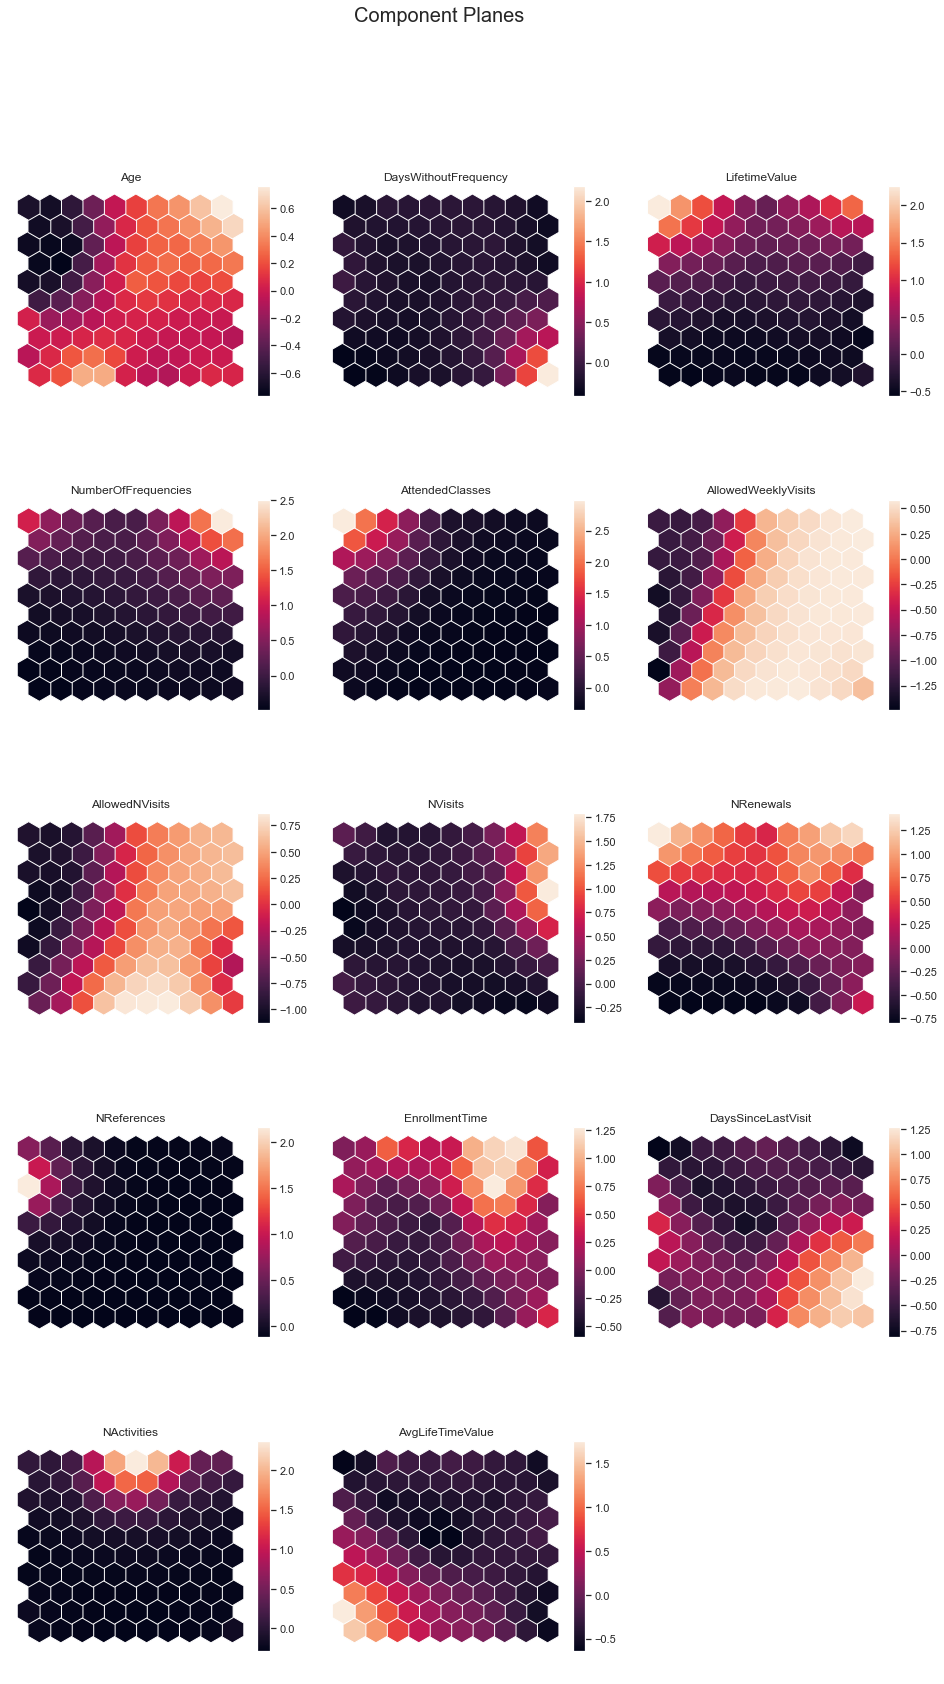

In [253]:
plt.rcParams['figure.dpi'] = 72


# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12, 12, "", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

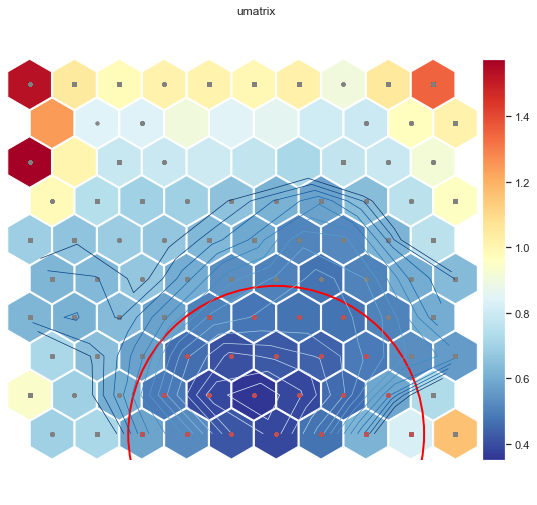

array([[1.53152405, 1.04835715, 0.98211511, 1.01274676, 1.0087689 ,
        0.99285164, 1.02066117, 0.9032418 , 1.05338578, 1.35100674],
       [1.2414626 , 0.83983203, 0.83508249, 0.90530609, 0.84903124,
        0.85630048, 0.80422376, 0.79592889, 0.96428584, 1.01174844],
       [1.576042  , 1.00493919, 0.78511792, 0.79159073, 0.80092023,
        0.76915858, 0.71574788, 0.77103623, 0.78826527, 0.91351296],
       [0.9877059 , 0.74615666, 0.70015918, 0.69349771, 0.65374775,
        0.61004735, 0.57498714, 0.64013192, 0.75807711, 0.95909707],
       [0.69028277, 0.65985646, 0.68180766, 0.67150807, 0.62456873,
        0.58717854, 0.51239017, 0.51620512, 0.61740554, 0.75571264],
       [0.62098687, 0.63360382, 0.66774296, 0.59844746, 0.53244092,
        0.50001756, 0.47313725, 0.50499013, 0.59596231, 0.63632604],
       [0.62254992, 0.61037627, 0.63767535, 0.57440124, 0.50082524,
        0.48068861, 0.47376756, 0.47590057, 0.50890726, 0.60030221],
       [0.71664447, 0.64672868, 0.5730609

In [254]:
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2,
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=True
)

np.flip(UMAT[1], axis=1)

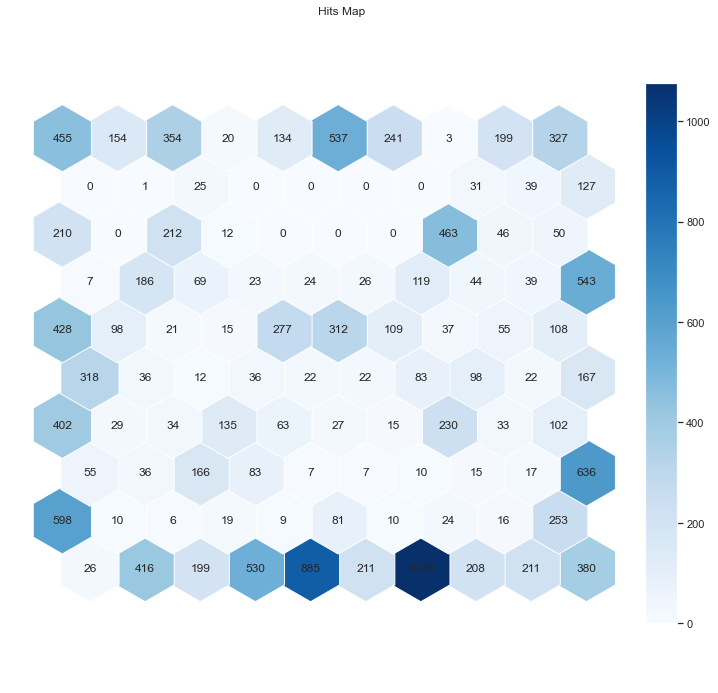

In [255]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

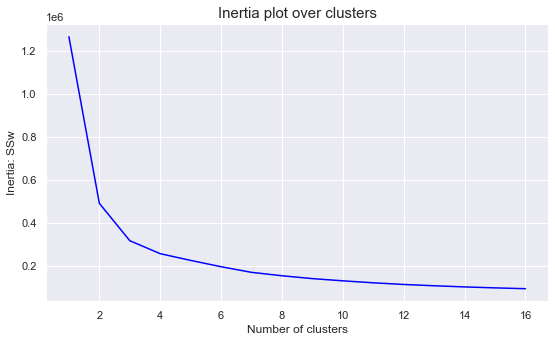

In [256]:
inertia = []
for n_clus in range(1,17): 
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=80)
    kmclust.fit(df2[metric_features])
    inertia.append(kmclust.inertia_)
    

plt.figure(figsize=(9,5))
plt.plot(range(1,17),inertia,color = 'blue')
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

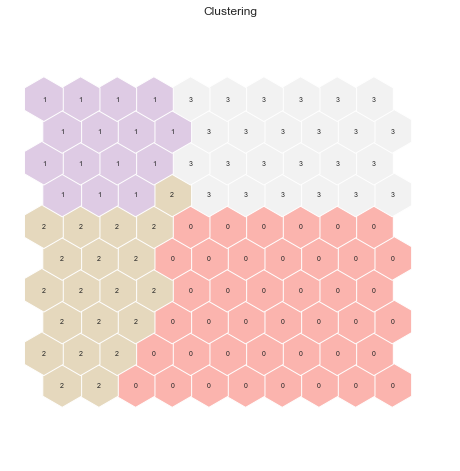

In [257]:
kmeans = KMeans(n_clusters=4,init='k-means++', n_init=20, random_state=42)

# Fit K-Means on the codebook matrix of the SOM
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)

sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

# Create a HitMapView for visualization
hits = HitMapView(8,8,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [258]:
# Extract the codebook matrix from the SOM
nodes = sm.codebook.matrix

# Create a DataFrame with the codebook matrix values
df_somk = pd.DataFrame(nodes, columns=metric_features)

# Add a column for the K-Means cluster labels
df_somk['som_kmeans_labels'] = nodeclus_labels
df_somk

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,EnrollmentTime,DaysSinceLastVisit,NActivities,AvgLifeTimeValue,som_kmeans_labels
0,0.765114,-0.295374,1.354771,2.507316,-0.238334,0.587465,0.596452,1.206392,1.306141,-0.079978,0.605283,-0.739564,0.367458,-0.532730,3
1,0.599275,-0.193616,1.006806,1.630544,-0.227546,0.558956,0.569425,0.632313,1.217498,-0.103781,1.239617,-0.570490,0.403121,-0.347263,3
2,0.428086,-0.145019,0.647526,0.901328,-0.185101,0.497682,0.453295,0.260244,1.000276,-0.107527,1.155194,-0.444306,1.044100,-0.318885,3
3,0.324268,-0.112113,0.482777,0.452727,-0.114907,0.417119,0.323079,-0.014352,0.821764,-0.105129,0.985087,-0.357869,2.003932,-0.253533,3
4,0.155558,-0.105645,0.182044,0.094459,-0.094464,0.302019,0.118246,-0.123664,0.396889,-0.102656,0.322957,-0.277453,2.365985,-0.212621,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.034966,-0.218811,-0.524359,-0.410408,-0.347555,0.563980,0.837545,-0.223299,-0.786810,-0.125214,-0.450168,-0.168876,-0.286728,0.278437,0
96,0.510007,-0.245397,-0.489397,-0.416233,-0.336866,0.498785,0.650446,-0.225487,-0.778493,-0.123999,-0.465283,-0.169158,-0.284447,0.514219,0
97,0.517715,-0.313962,-0.513920,-0.437339,-0.313082,0.311310,0.134836,-0.174170,-0.783310,-0.121536,-0.520336,-0.144182,-0.276299,0.796529,0
98,0.211332,-0.385641,-0.558178,-0.478032,-0.295515,0.032977,-0.320791,-0.108194,-0.804050,-0.119579,-0.600328,-0.128803,-0.260382,1.233965,2


In [259]:
bmus_map = sm.find_bmu(df2[metric_features].values)[0]  #get bmus for each observation in df
df_bmus = pd.DataFrame(
    np.concatenate((df2[metric_features], np.expand_dims(bmus_map,1)), axis=1),
    index=df2[metric_features].index, columns=np.append(df2[metric_features].columns,"BMU")
)
df_bmus

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,EnrollmentTime,DaysSinceLastVisit,NActivities,AvgLifeTimeValue,BMU
ID,,,,,,,,,,,,,,,
10000,3.083333,-0.571429,-0.282972,-0.243243,2.333333,-2.333333,-0.929988,-0.333333,-0.5,0.0,-0.374172,-0.623519,0.0,1.160353,69.0
10001,0.500000,0.271429,1.213861,0.135135,0.333333,-1.666667,-0.613263,-0.500000,0.5,0.0,0.751656,0.804923,0.0,0.699230,49.0
10002,0.000000,-0.485714,-0.481666,-0.324324,0.000000,0.000000,-0.254744,0.333333,-0.5,0.0,-0.466887,0.185962,0.0,0.766811,77.0
10003,-1.166667,-0.271429,-0.029372,0.054054,0.666667,-1.666667,-0.604734,-0.166667,-0.5,0.0,-0.036424,-0.366454,0.0,0.380252,48.0
10005,0.083333,-0.542857,-0.088501,0.270270,0.000000,0.000000,0.569195,3.666667,-0.5,0.0,0.238411,0.460346,0.0,-0.161216,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,-0.750000,-0.557143,4.981378,2.540541,32.000000,-1.000000,-0.117990,0.666667,1.0,0.0,-0.566225,-0.622607,0.0,-0.950742,9.0
24938,1.333333,-0.042857,0.694183,1.054054,0.000000,0.000000,0.624920,-0.166667,-0.5,0.0,0.298013,0.544211,0.0,0.854627,41.0
24939,-0.250000,-0.557143,-0.458629,-0.324324,0.000000,0.000000,-0.254744,0.666667,-0.5,0.0,-0.466887,0.237922,0.0,1.040886,98.0


In [260]:
df_somk_1 = df_bmus.merge(df_somk['som_kmeans_labels'], 'left', left_on="BMU", right_index=True)

df_somk_1.drop('BMU', axis=1, inplace=True)

In [261]:
df_somk_1.groupby('som_kmeans_labels')[metric_features].mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,EnrollmentTime,DaysSinceLastVisit,NActivities,AvgLifeTimeValue
som_kmeans_labels,,,,,,,,,,,,,,
0,0.357237,1.281742,-0.126852,-0.088383,0.082477,-0.059177,0.311691,-0.066055,-0.180815,0.005895,0.154234,0.326497,0.033350,-0.069347
1,-0.346022,0.200227,1.701033,0.974413,14.231380,-1.392144,-0.468159,0.092078,0.478484,0.069513,0.563926,-0.148385,0.132075,-0.103178
2,-0.050330,-0.136011,-0.222656,-0.260369,0.451320,-1.111881,-0.399717,-0.005198,-0.396040,0.006436,-0.293387,-0.077204,0.036139,0.969163
3,0.749366,-0.042722,0.884903,1.764870,0.078569,-0.009530,0.395096,0.949919,0.450122,0.009124,1.009951,-0.179330,0.183698,-0.224430


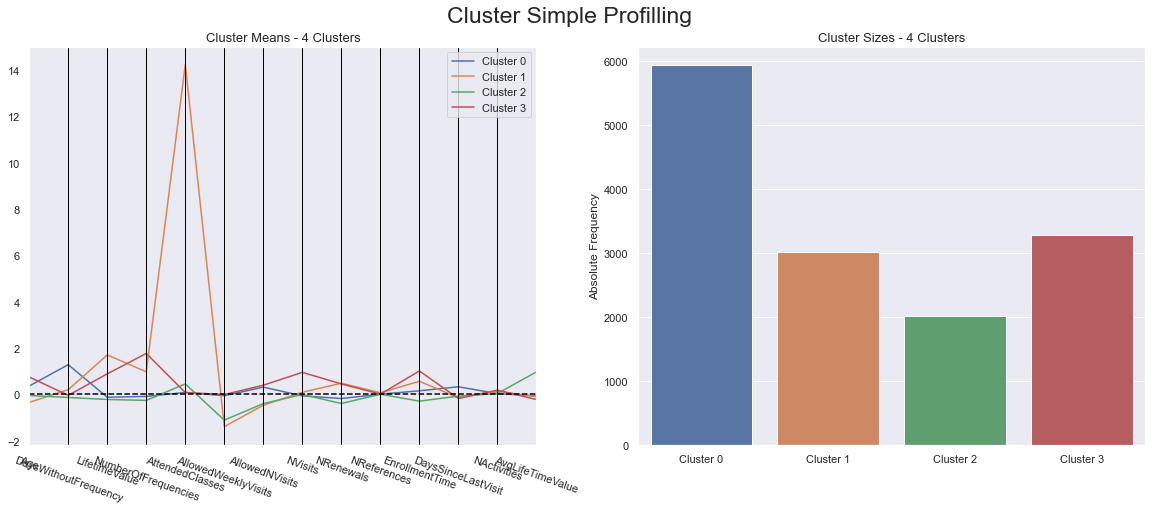

In [262]:
cluster_profiles(df_somk_1, ['som_kmeans_labels'], (20,7))

In [263]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_somk_1[metric_features])  # get total sum of squares
ssw_labels = df_somk_1[metric_features + ["som_kmeans_labels"]].groupby(by='som_kmeans_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.4066052131959556

In [264]:
silhouette_avg = silhouette_score(df_somk[metric_features], nodeclus_labels)
round(silhouette_avg,3)

0.327

In [265]:
kmeans_db_index = davies_bouldin_score(df_somk[metric_features], nodeclus_labels)
round(kmeans_db_index,3)

1.032

# Hierarchical clustering + K-means

In [270]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_som)

array([13239,  8181, 12463, ...,     2,     1,     0])

In [271]:
counts = np.zeros(hclust.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'shape'

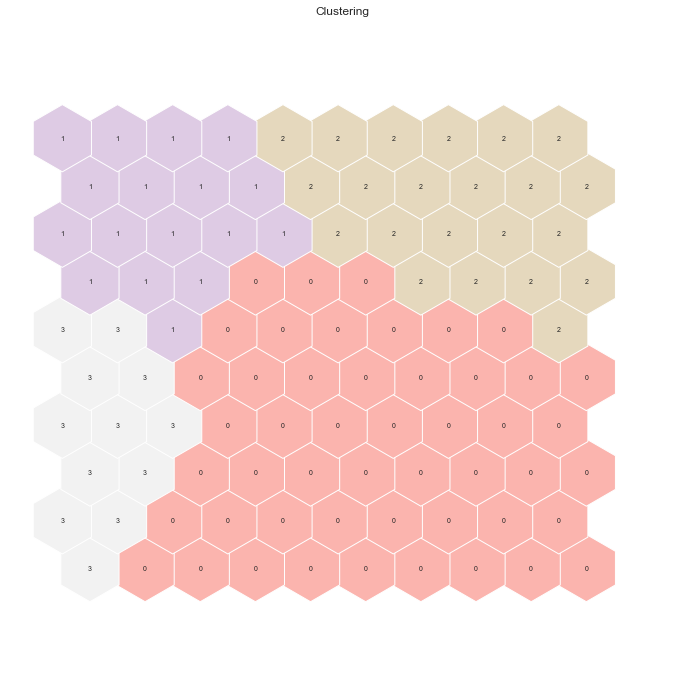

In [269]:
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [ ]:
nodes = sm.codebook.matrix

hnodes = pd.DataFrame(nodes, columns=value_features)
hnodes['som_hierar_labels'] = node_hier_label
hnodes

In [ ]:
bmus_ = sm.find_bmu(df_value[value_features].values)[0]

df_bmus = pd.DataFrame(
    np.concatenate((df_value, np.expand_dims(bmus_,1)), axis=1),
    index=df_value.index, columns=np.append(df_value.columns,"BMU")
)
df_bmus


In [ ]:
df_somh = df_bmus.merge(hnodes['som_hierar_labels'], 'left', left_on="BMU", right_index=True)

df_somh.drop('BMU', axis=1, inplace=True)

In [ ]:
cluster_profiles(df_somh, ['som_hierar_labels'], (20,7))

In [ ]:
df_somh.groupby('som_hierar_labels')[value_features].mean()

# Mean shift

In [272]:
df_meanshift = data.copy()

In [275]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth_value = estimate_bandwidth(df_meanshift, quantile=0.25, random_state=80, n_jobs=-1)
bandwidth_value

6.037489144903099

In [276]:
mean_shift = MeanShift(bandwidth=bandwidth_value, bin_seeding=True, n_jobs=4)
mean_shift_labels = mean_shift.fit_predict(df_meanshift)

mean_shift_clusters = len(np.unique(mean_shift_labels))
print("Number of estimated clusters : %d" % mean_shift_clusters)

Number of estimated clusters : 10


In [277]:
df_mean_shift = pd.concat([df_meanshift, pd.Series(mean_shift_labels, name='mean_shift_labels', index=df_meanshift.index)], axis=1)

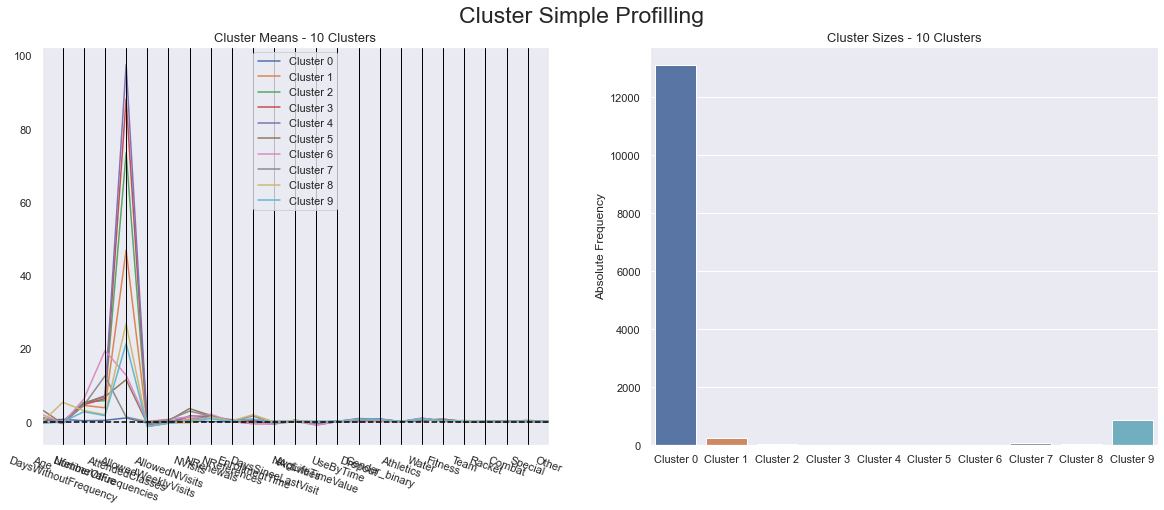

In [278]:
cluster_profiles(df_mean_shift, ['mean_shift_labels'], (20,7))

In [280]:
df_mean_shift.groupby('mean_shift_labels')[metric_features].mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,EnrollmentTime,DaysSinceLastVisit,NActivities,AvgLifeTimeValue
mean_shift_labels,,,,,,,,,,,,,,
0,0.289384,0.591723,0.233071,0.337195,0.996251,-0.406631,0.105957,0.182823,-0.006389,0.014002,0.341627,0.088490,0.084468,0.065508
1,-0.226296,-0.214032,4.414038,3.769249,46.841481,-1.262222,-0.374917,0.645926,1.322222,0.155556,0.533907,-0.482512,0.151111,-0.493857
2,0.712963,-0.379365,5.309974,5.720721,73.407407,-1.277778,-0.376604,1.527778,1.500000,0.055556,-0.100442,-0.588119,0.333333,-0.828455
3,0.833333,-0.503571,4.625168,6.297297,88.083333,-1.250000,-0.405217,1.416667,1.750000,0.000000,0.295530,-0.615087,0.250000,-0.645973
4,0.604167,0.067857,4.969380,7.047297,97.500000,-1.000000,-0.121970,1.333333,1.375000,0.500000,0.587748,-0.478578,0.000000,-0.510822
5,3.305556,-0.557143,5.063736,6.810811,11.444444,-0.555556,0.212192,3.555556,1.666667,0.000000,-0.566225,-0.622607,0.333333,-0.950742
6,2.000000,-0.442857,6.144366,19.378378,12.666667,0.000000,0.624920,1.333333,2.000000,0.000000,-0.566225,-0.615314,0.000000,-0.950742
7,1.269531,-0.391071,4.455278,12.470861,1.250000,-0.015625,0.469863,2.856771,1.554688,0.015625,1.562190,-0.524513,0.390625,-0.279223
8,-0.313596,5.266165,3.000475,1.889758,26.763158,-1.307018,-0.441890,-0.342105,1.236842,0.210526,1.855699,-0.052632,0.289474,-0.172723


# DBSCAN

In [50]:
df5 = data.copy()

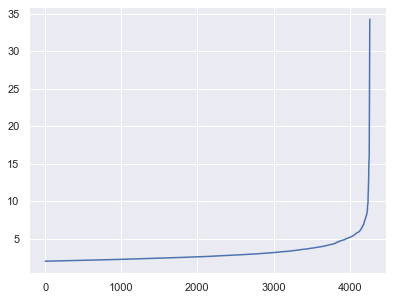

In [285]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

# Radius of cluster
neigh = NearestNeighbors(n_neighbors=27)
neigh.fit(df5)
distances, _ = neigh.kneighbors(df5)
distances = np.sort(distances[:, -1])
plt.plot(distances[10000:])
plt.show()

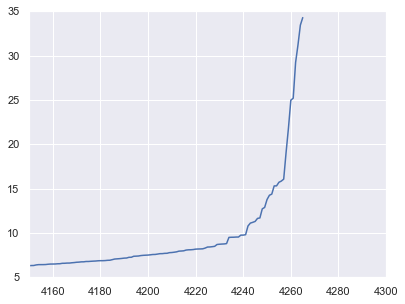

In [298]:
plt.plot(distances[10000:])
plt.axis([4150, 4300, 5,35])
plt.show()

In [287]:
dbscan = DBSCAN(eps=2.5, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df5)

dbscan_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_clusters)

Number of estimated clusters : 8


In [288]:
df_dbscan = pd.concat([df5, pd.Series(dbscan_labels, name='dbscan_labels', index=df5.index)], axis=1)

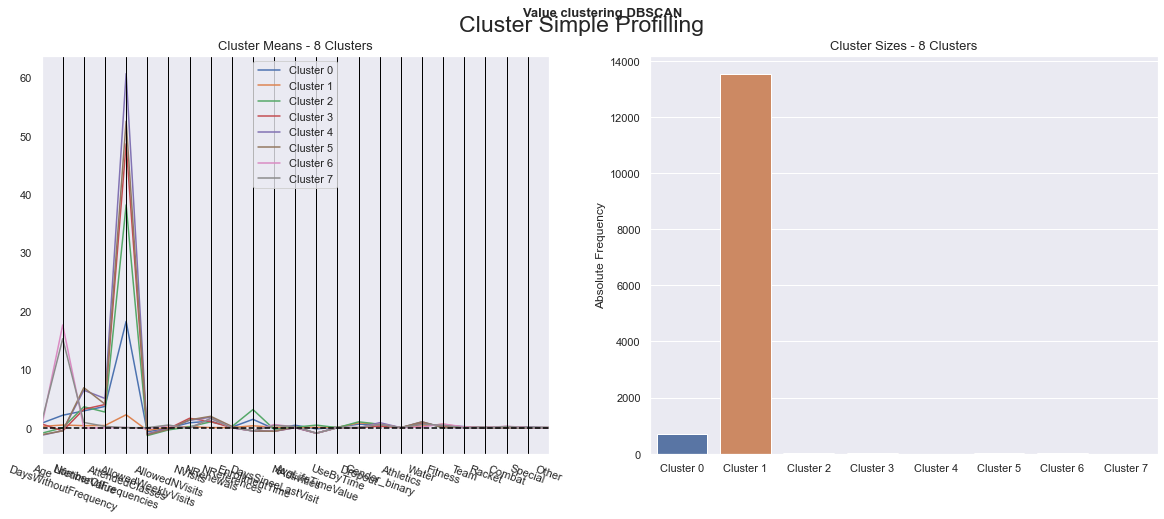

In [289]:
cluster_profiles(
    df = df_dbscan, 
    label_columns = ['dbscan_labels'], 
    figsize = (20, 7), 
    compar_titles = ["Value clustering DBSCAN"]
)

In [291]:
df_dbscan.groupby('dbscan_labels')[metric_features].mean()

,Age,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisits,AllowedNVisits,NVisits,NRenewals,NReferences,EnrollmentTime,DaysSinceLastVisit,NActivities,AvgLifeTimeValue
dbscan_labels,,,,,,,,,,,,,,
-1,0.762984,2.127883,2.876843,3.636628,18.206799,-0.719075,-0.047771,0.840179,1.118272,0.087819,1.423592,-0.197702,0.416431,-0.206042
0,0.215987,0.451300,0.342270,0.368460,2.210656,-0.464747,0.071630,0.175082,0.013882,0.016436,0.320451,0.066530,0.072259,0.050019
1,-0.958333,-0.026190,3.580850,2.675676,38.166667,-1.361111,-0.386073,0.152778,1.000000,0.166667,3.100166,-0.274613,0.083333,0.433987
2,0.645833,-0.559524,3.161986,3.961712,48.638889,-1.083333,-0.183927,1.611111,1.041667,0.000000,-0.566225,-0.622759,0.000000,-0.950742
3,-1.309524,-0.520408,6.411063,5.003861,60.666667,-1.095238,-0.228141,1.261905,1.785714,0.000000,-0.566225,-0.620263,0.000000,-0.950742
4,-1.212963,-0.546032,6.852205,4.027027,52.518519,-1.222222,-0.283081,1.333333,1.944444,0.222222,-0.566225,-0.621898,0.111111,-0.950742
5,0.114583,17.598214,-0.066376,-0.043919,0.041667,-0.166667,0.350380,-0.062500,1.562500,0.000000,-0.566225,0.535893,0.125000,-0.950742
6,0.950000,15.234286,0.894605,0.221622,0.000000,0.000000,0.448987,-0.133333,1.600000,0.000000,-0.566225,0.385050,0.200000,-0.950742


In [299]:
silhouette_avg = silhouette_score(df_dbscan[metric_features], dbscan_labels)
round(silhouette_avg,3)

0.513